# Explainable AI Notebook

## Imports

In [29]:
# Set root directory of the project as the current working directory
import os
import sys

module_path = os.path.abspath('..')
if module_path not in sys.path:
    %cd ..

In [30]:
# ======================
# Standard Library
# ======================
import logging
import random

# ======================
# Third-Party Libraries
# ======================
from ipywidgets import IntSlider, interact
import kerastuner as kt
import lime
from lime.lime_tabular import LimeTabularExplainer
import mat4py as mpy
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import shap
import datetime
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

# ======================
# TensorFlow / Keras
# ======================
import tensorflow as tf
"""
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPooling1D
)
"""
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.utils import to_categorical

# ======================
# Custom Modules
# ======================
from config.defaults import Config
from src.evaluation import evaluate_regression_model, evaluate_classification_model
from src.models import load_preprocessed_data, load_saved_model
from src.utils import plot_predictions_vs_actual

# ======================
# Configuration
# ======================
logging.getLogger().setLevel(logging.WARNING)
config = Config()


## Data loading

In [31]:
# Load preprocessed data for the specified dataset
config.use_aachen = False # Activate Mit_Stanford dataset

dataset = "aachen" if config.use_aachen else "mit_stanford"


# Regression
config.model_task = "lstm_regression" # Activate regression task
X_train, X_val, X_test, y_train_reg, y_val_reg, y_test_reg, metadata = load_preprocessed_data(
    config.model_task, config.eol_capacity, config.use_aachen
)

# Classification
config.model_task = "classification" # Activate classification task
X_train, X_val, X_test, y_train_clf, y_val_clf, y_test_clf, metadata = load_preprocessed_data(
    config.model_task, config.eol_capacity, config.use_aachen
)

classification_labels = config.labels
n_timesteps = config.seq_len

# Flatten input data for models requiring 2D input
n_samples, timesteps, n_features = X_train.shape
X_train_flat = X_train.reshape(n_samples, timesteps * n_features)
X_val_flat   = X_val.reshape(X_val.shape[0], timesteps * n_features)
X_test_flat  = X_test.reshape(X_test.shape[0], timesteps * n_features)



## Data visualization

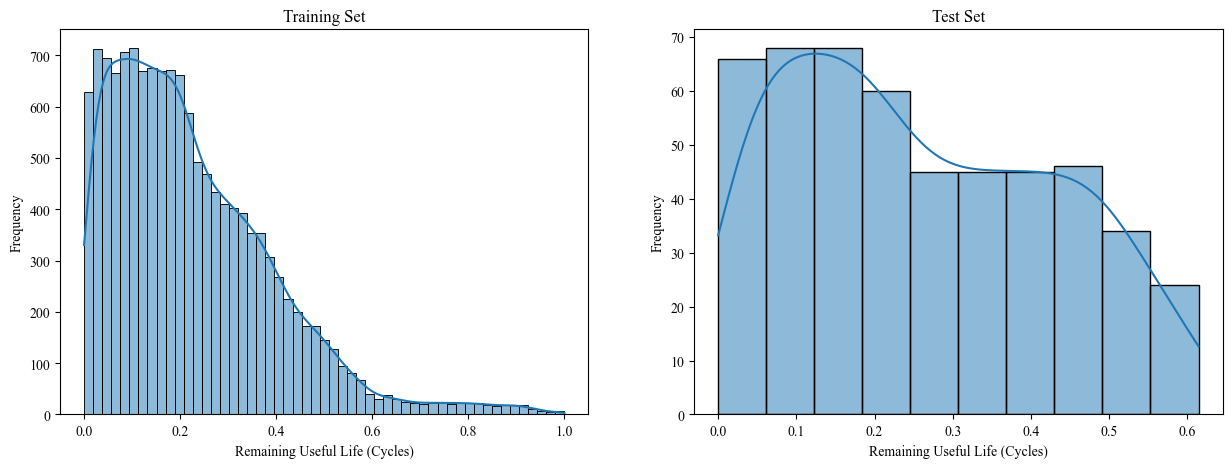

In [32]:
# Plot the distribution of the target variable
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(y_train_reg, ax=ax[0], kde=True)
ax[0].set_title("Training Set")
ax[0].set_xlabel("Remaining Useful Life (Cycles)")
ax[0].set_ylabel("Frequency")

sns.histplot(y_test_reg, ax=ax[1], kde=True)
ax[1].set_title("Test Set")
ax[1].set_xlabel("Remaining Useful Life (Cycles)")
ax[1].set_ylabel("Frequency")

plt.show()


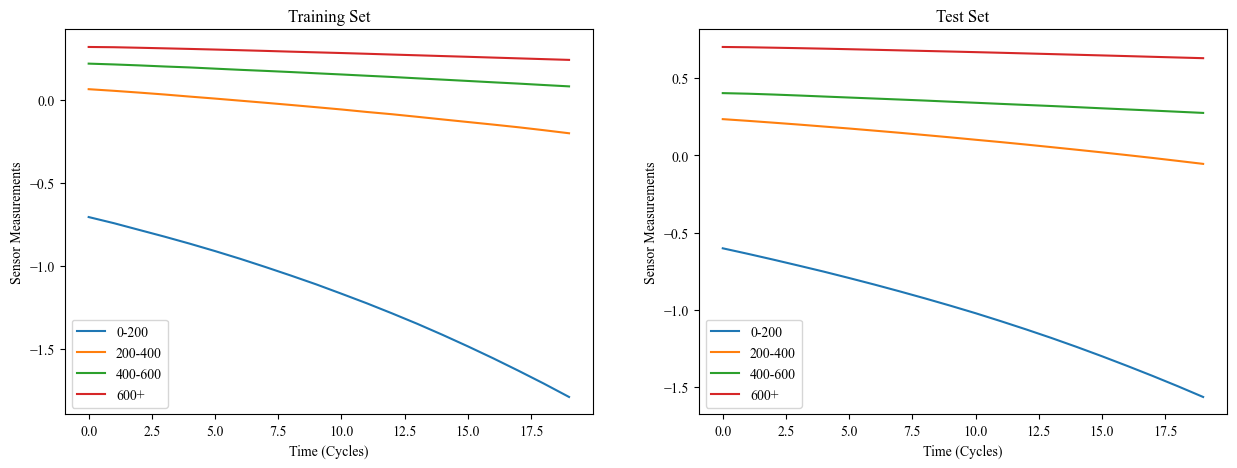

In [33]:
# Plot the average time series for each class

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for i in range(config.n_bins):
    mask = np.argmax(y_train_clf, axis=1) == i
    avg_time_series = X_train[mask].mean(axis=0).squeeze()
    ax[0].plot(avg_time_series, label=classification_labels[i])

ax[0].set_title("Training Set")
ax[0].set_xlabel("Time (Cycles)")
ax[0].set_ylabel("Sensor Measurements")
ax[0].legend()

for i in range(config.n_bins):
    mask = np.argmax(y_test_clf, axis=1) == i
    avg_time_series = X_test[mask].mean(axis=0).squeeze()
    ax[1].plot(avg_time_series, label=classification_labels[i])

ax[1].set_title("Test Set")
ax[1].set_xlabel("Time (Cycles)")
ax[1].set_ylabel("Sensor Measurements")
ax[1].legend()

plt.show()




In [34]:

# Assuming X_train is your training set array.
# For instance, X_train might have shape (n_samples, n_timesteps, 1).

# Randomly select 50 samples from the training set
n_samples_total = X_train.shape[0]
selected_indices = np.random.choice(n_samples_total, size=50, replace=False)
X_random = X_train[selected_indices]

# If X_random has shape (50, n_timesteps, 1), squeeze the last dimension
if len(X_random.shape) == 3:
    n_samples, n_timesteps, n_features = X_random.shape
    if n_features == 1:
        X_random = X_random.squeeze(axis=-1)  # now shape is (n_samples, n_timesteps)
    else:
        raise ValueError("Expected feature dimension to be 1 for plotting a single time series per sample.")
else:
    n_samples, n_timesteps = X_random.shape

# Create a DataFrame where each row is a sample and each column is a timestep
df = pd.DataFrame(X_random, columns=[f"timestep_{i}" for i in range(n_timesteps)])
df["sample"] = selected_indices  # Label the samples with their original indices

# Melt the DataFrame to long format: each row becomes (sample, timestep, value)
df_long = df.melt(id_vars="sample", var_name="timestep", value_name="value")
# Convert the 'timestep' column from "timestep_0" to an integer (0)
df_long["timestep"] = df_long["timestep"].str.replace("timestep_", "").astype(int)

# Create a line plot with Plotly Express: one line per sample
fig = px.line(
    df_long,
    x="timestep",
    y="value",
    color="sample",
    title="Time Series of 50 Random Training Samples",
    labels={"timestep": "Timestep", "value": "Capacity Value", "sample": "Sample Index"}
)

fig.show()


## Load and Evaluate models

### Regression

#### LSTM

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169 - mae: 0.1073  


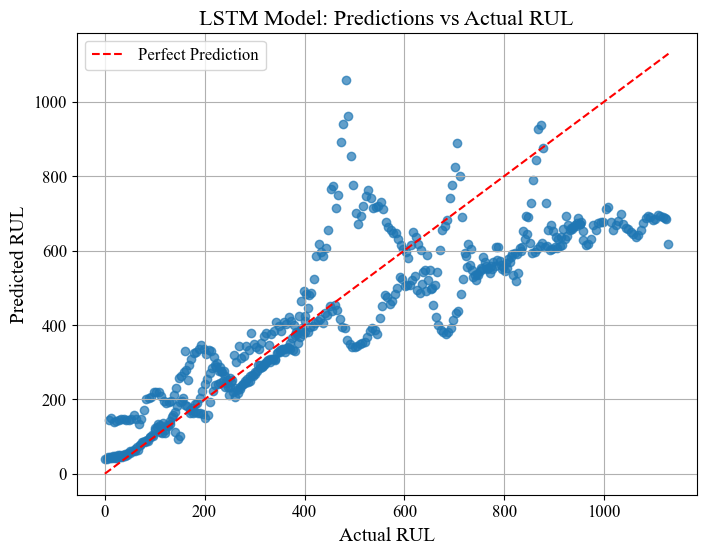

In [35]:
config.model_task = "lstm_regression"  # Set the model task
config.use_aachen = False  # Set the dataset

lstm_model = load_saved_model(config)

regression_metrics = {}

y_pred = lstm_model.predict(X_test)

# Evaluate the model
regression_metrics['LSTM'] = evaluate_regression_model(lstm_model, X_test, y_test_reg, metadata["y_max"])

# Plot predictions vs actual values
plot_predictions_vs_actual(config, y_test_reg, y_pred, metadata["y_max"], title="LSTM Model: Predictions vs Actual RUL")


#### Interpretable Alternatives

#### DecisionTree Regressor

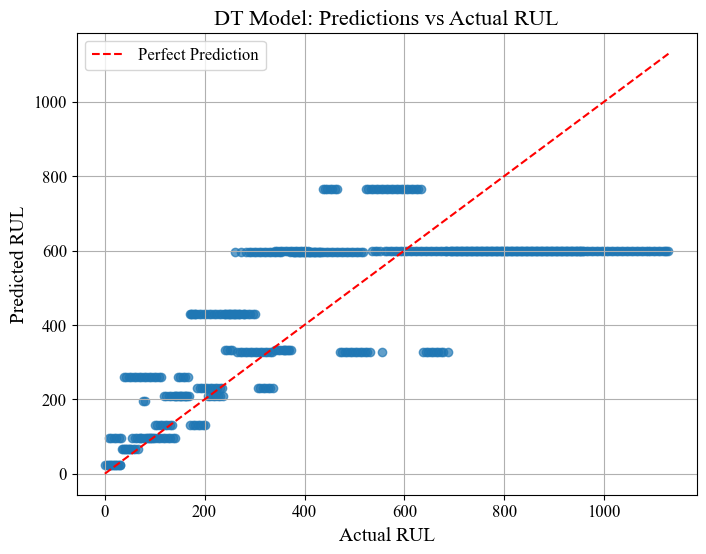

In [36]:
config.use_aachen = False # Activate MIT_Stanford dataset
config.model_task = "dt_regression" 

dt_regressor = load_saved_model(config)

y_pred = dt_regressor.predict(X_test_flat)
regression_metrics['DecisionTree'] = evaluate_regression_model(dt_regressor, X_test_flat, y_test_reg, metadata["y_max"])

plot_predictions_vs_actual(config, y_test_reg, y_pred, metadata["y_max"], title="DT Model: Predictions vs Actual RUL")

#### Linear Regression

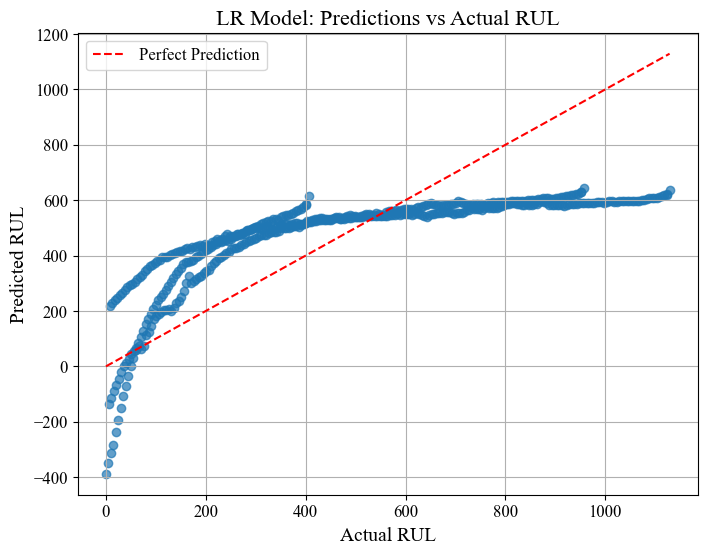

In [37]:
config.use_aachen = False # Activate MIT_Stanford dataset
config.model_task = "lr_regression" 

lin_reg = load_saved_model(config)

y_pred = lin_reg.predict(X_test_flat)
regression_metrics['LinearRegression'] = evaluate_regression_model(lin_reg, X_test_flat, y_test_reg, metadata["y_max"])

plot_predictions_vs_actual(config, y_test_reg, y_pred, metadata["y_max"], title="LR Model: Predictions vs Actual RUL")

#### Lasso Regression

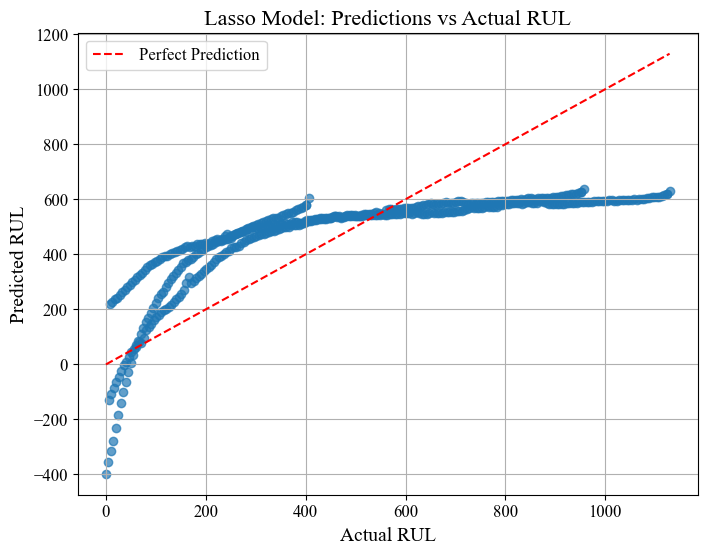

In [38]:
config.use_aachen = False # Activate MIT_Stanford dataset
config.model_task = "lasso_regression" 

lasso_reg = load_saved_model(config)

y_pred = lasso_reg.predict(X_test_flat)
regression_metrics['Lasso'] = evaluate_regression_model(lasso_reg, X_test_flat, y_test_reg, metadata["y_max"])

plot_predictions_vs_actual(config, y_test_reg, y_pred, metadata["y_max"], title="Lasso Model: Predictions vs Actual RUL")

In [39]:
regression_metrics_df = pd.DataFrame(regression_metrics, index=[
    'RMSE', 'MAE', 'R2', 'Rescaled RMSE', 'Rescaled MAE',
])
regression_metrics_df = regression_metrics_df.T

regression_metrics_df

,RMSE,MAE,R2,Rescaled RMSE,Rescaled MAE
LSTM,0.094196,0.068265,0.687731,173.133157,125.470812
DecisionTree,0.114861,0.092083,0.535696,211.113886,169.248753
LinearRegression,0.115802,0.098182,0.528057,212.843358,180.459301
Lasso,0.115798,0.098185,0.528087,212.836703,180.464053


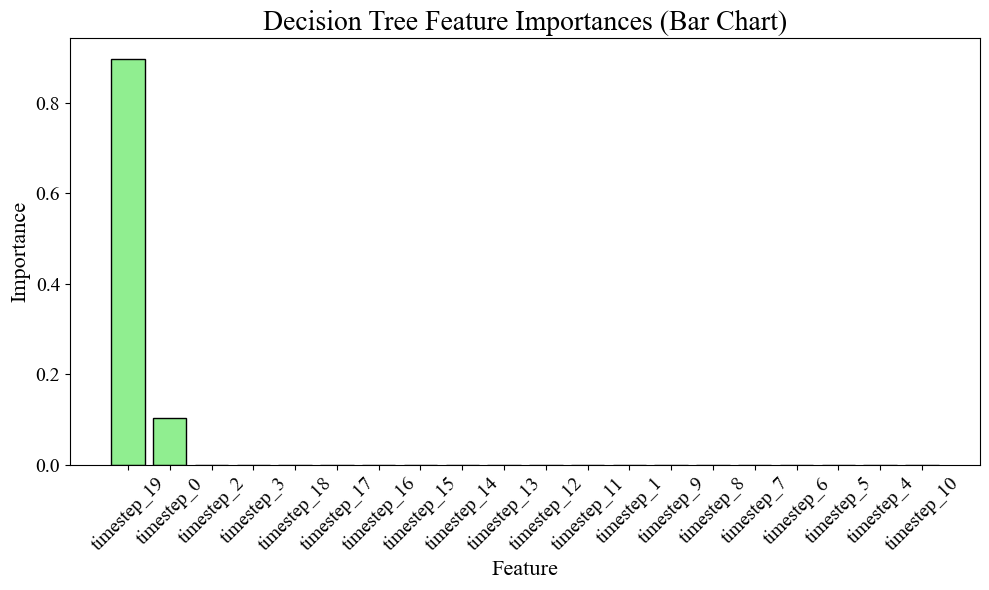

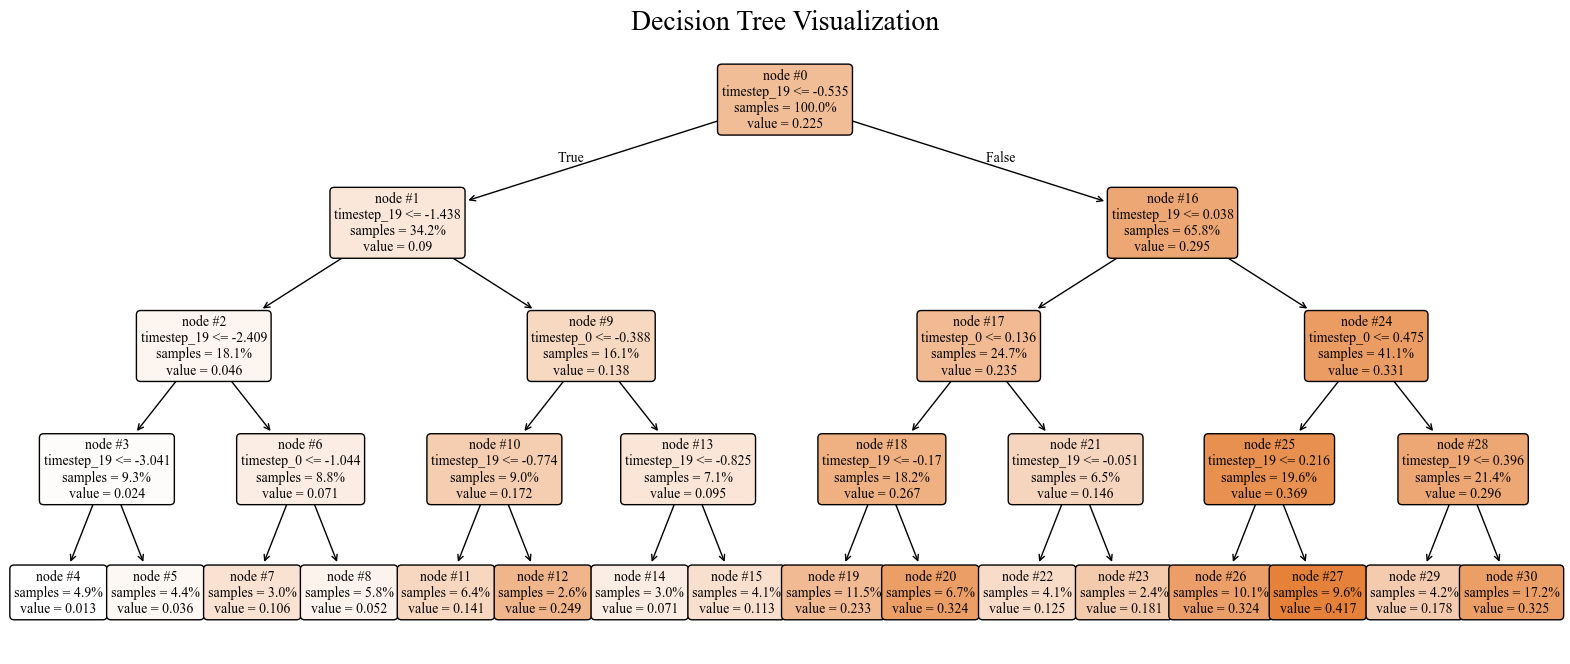

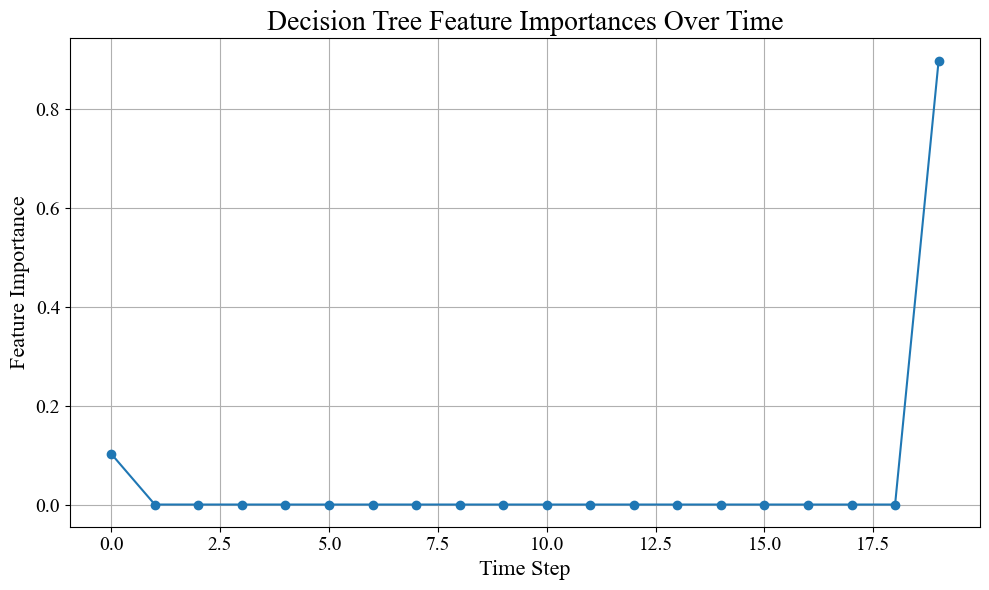

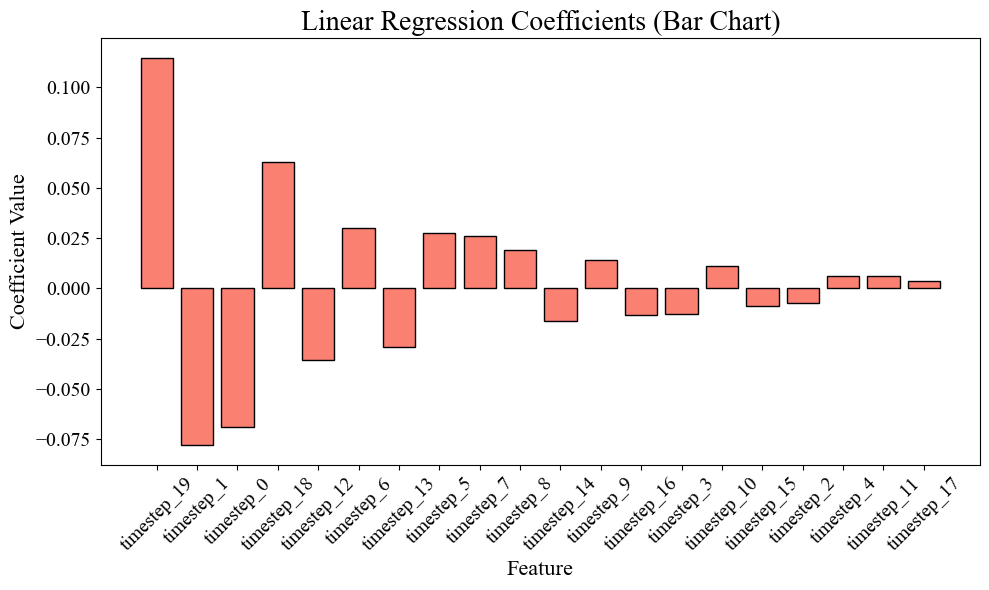

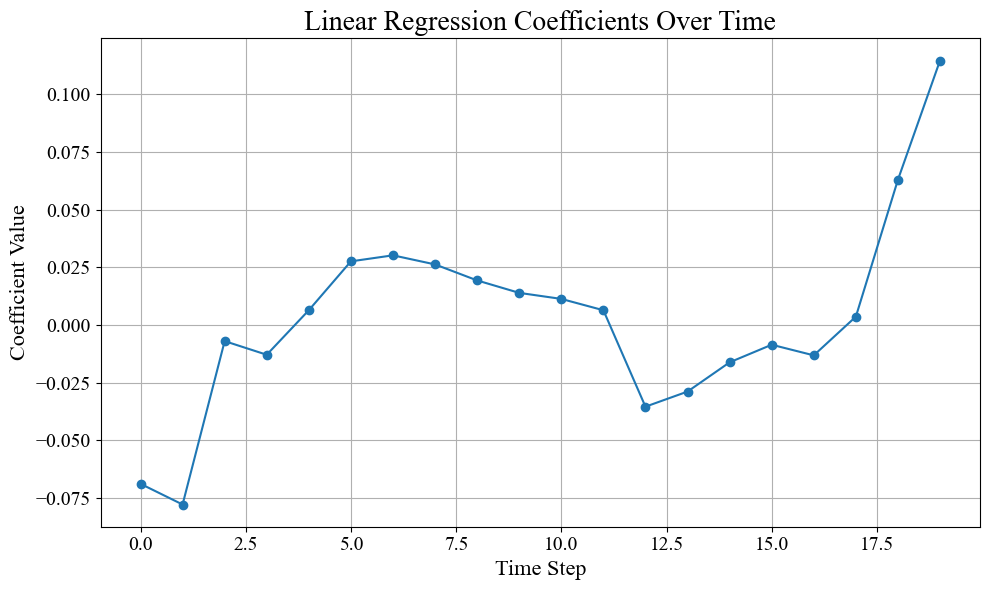

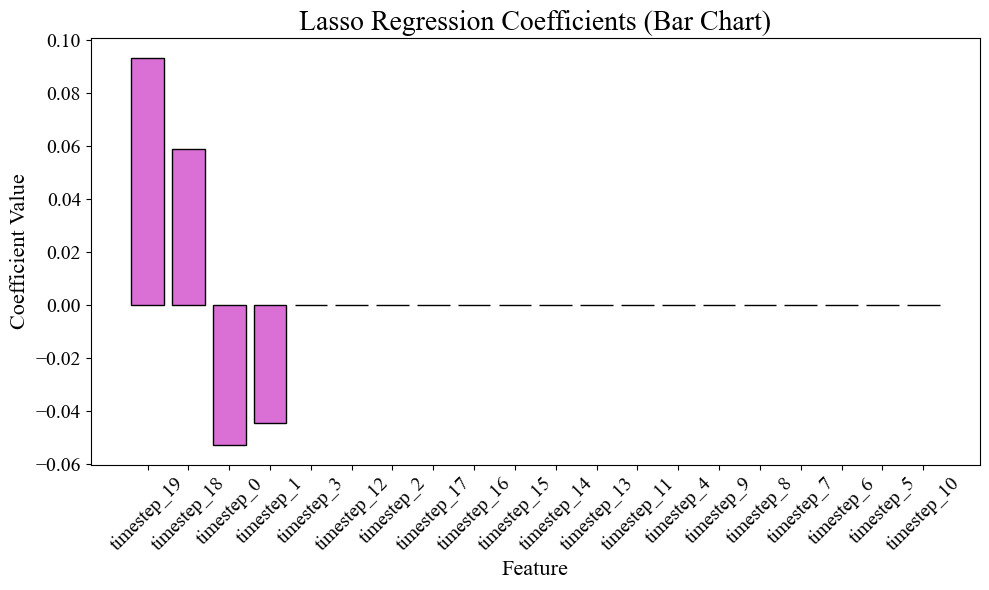

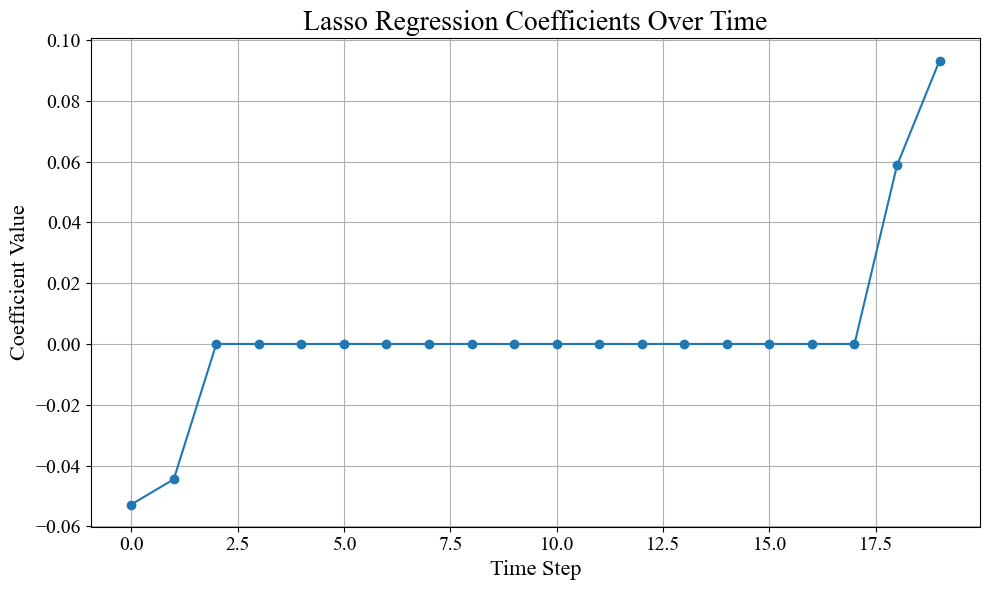

In [40]:

# Create a feature name list for each timestep (adjust the number of timesteps as needed)
feature_names = [f"timestep_{i}" for i in range(20)]

# Convert feature names to numeric timesteps for continuous plots
timesteps = np.array([int(f.split('_')[-1]) for f in feature_names])

# Determine subfolder based on config.use_aachen
bottom_map_dir = "aachen" if config.use_aachen else "mit_stanford"
output_dir = os.path.join("experiments", "results", bottom_map_dir)
os.makedirs(output_dir, exist_ok=True)

# ============================================================
# 1. Decision Tree Regressor: Feature Importances & Visualization
# ============================================================

config.model_task = "dt_regression"

# --- Bar Chart & DataFrame ---
dt_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_regressor.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(dt_importances_df['Feature'], dt_importances_df['Importance'], color='lightgreen', edgecolor='k')
plt.xlabel("Feature", fontsize=16)
plt.ylabel("Importance", fontsize=16)
plt.title("Decision Tree Feature Importances (Bar Chart)", fontsize=20)
plt.xticks(rotation=45)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()

timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f"{config.model_task}_feature_importances_bar_{dataset}_{timestamp}.pdf"
plt.savefig(os.path.join(output_dir, filename), format='pdf', bbox_inches='tight')
plt.show()

# --- Tree Visualization ---
plt.figure(figsize=(20, 8))
plot_tree(
    dt_regressor,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    fontsize=10,
    impurity=False,
    node_ids=True,
    proportion=True
)
plt.title("Decision Tree Visualization", fontsize=20)

timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f"{config.model_task}_tree_visualization_{dataset}_{timestamp}.pdf"
plt.savefig(os.path.join(output_dir, filename), format='pdf', bbox_inches='tight')
plt.show()

# --- Continuous Plot of Feature Importances ---
plt.figure(figsize=(10, 6))
plt.plot(timesteps, dt_regressor.feature_importances_, marker='o', linestyle='-')
plt.xlabel("Time Step", fontsize=16)
plt.ylabel("Feature Importance", fontsize=16)
plt.title("Decision Tree Feature Importances Over Time", fontsize=20)
plt.tick_params(axis='both', labelsize=14)
plt.grid(True)
plt.tight_layout()

timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f"{config.model_task}_feature_importances_line_{dataset}_{timestamp}.pdf"
plt.savefig(os.path.join(output_dir, filename), format='pdf', bbox_inches='tight')
plt.show()

# ============================================================
# 2. Linear Regression: Coefficients & Visualization
# ============================================================

config.model_task = "lr_regression"

# --- Bar Chart & DataFrame (sorted by absolute coefficient value) ---
lin_coefs_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lin_reg.coef_
}).sort_values(by='Coefficient', key=lambda x: np.abs(x), ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(lin_coefs_df['Feature'], lin_coefs_df['Coefficient'], color='salmon', edgecolor='k')
plt.xlabel("Feature", fontsize=16)
plt.ylabel("Coefficient Value", fontsize=16)
plt.title("Linear Regression Coefficients (Bar Chart)", fontsize=20)
plt.xticks(rotation=45)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()

timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f"{config.model_task}_coefficients_bar_{dataset}_{timestamp}.pdf"
plt.savefig(os.path.join(output_dir, filename), format='pdf', bbox_inches='tight')
plt.show()

# --- Continuous Plot of Coefficients ---
plt.figure(figsize=(10, 6))
plt.plot(timesteps, lin_reg.coef_, marker='o', linestyle='-')
plt.xlabel("Time Step", fontsize=16)
plt.ylabel("Coefficient Value", fontsize=16)
plt.title("Linear Regression Coefficients Over Time", fontsize=20)
plt.tick_params(axis='both', labelsize=14)
plt.grid(True)
plt.tight_layout()

timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f"{config.model_task}_coefficients_line_{dataset}_{timestamp}.pdf"
plt.savefig(os.path.join(output_dir, filename), format='pdf', bbox_inches='tight')
plt.show()

# ============================================================
# 3. Lasso Regression: Coefficients & Visualization
# ============================================================

config.model_task = "lasso_regression"

# --- Bar Chart & DataFrame (sorted by absolute coefficient value) ---
lasso_coefs_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_reg.coef_
}).sort_values(by='Coefficient', key=lambda x: np.abs(x), ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(lasso_coefs_df['Feature'], lasso_coefs_df['Coefficient'], color='orchid', edgecolor='k')
plt.xlabel("Feature", fontsize=16)
plt.ylabel("Coefficient Value", fontsize=16)
plt.title("Lasso Regression Coefficients (Bar Chart)", fontsize=20)
plt.xticks(rotation=45)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()

timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f"{config.model_task}_coefficients_bar_{dataset}_{timestamp}.pdf"
plt.savefig(os.path.join(output_dir, filename), format='pdf', bbox_inches='tight')
plt.show()

# --- Continuous Plot of Lasso Coefficients ---
plt.figure(figsize=(10, 6))
plt.plot(timesteps, lasso_reg.coef_, marker='o', linestyle='-')
plt.xlabel("Time Step", fontsize=16)
plt.ylabel("Coefficient Value", fontsize=16)
plt.title("Lasso Regression Coefficients Over Time", fontsize=20)
plt.tick_params(axis='both', labelsize=14)
plt.grid(True)
plt.tight_layout()

timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f"{config.model_task}_coefficients_line_{dataset}_{timestamp}.pdf"
plt.savefig(os.path.join(output_dir, filename), format='pdf', bbox_inches='tight')
plt.show()

### Classification

#### 1D Convolutional Neural Network

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7249 - loss: 0.7090  


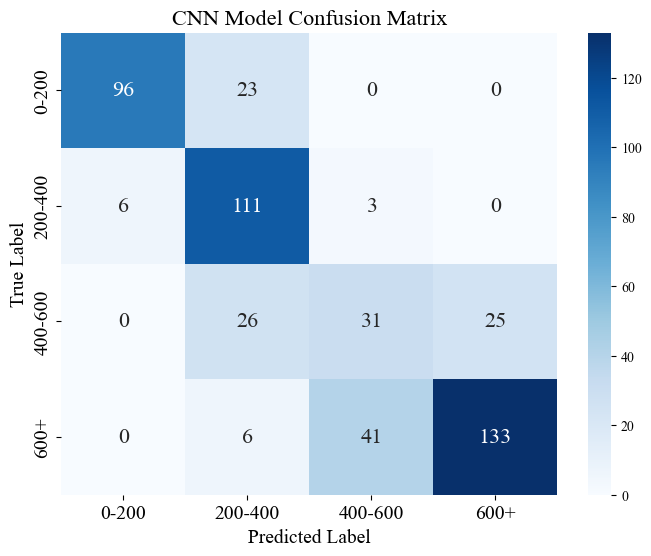

              precision    recall  f1-score   support

       0-200       0.94      0.81      0.87       119
     200-400       0.67      0.93      0.78       120
     400-600       0.41      0.38      0.39        82
        600+       0.84      0.74      0.79       180

    accuracy                           0.74       501
   macro avg       0.72      0.71      0.71       501
weighted avg       0.75      0.74      0.74       501



In [41]:
config.use_aachen = False  # Activate MIT_Stanford dataset
config.model_task = "cnn_classification"  

classification_metrics = {} # For storing classification metrics

cnn_model = load_saved_model(config)

classification_metrics["CNN"] = evaluate_classification_model(config, cnn_model, X_test, y_test_clf, labels=config.labels, title="CNN Model Confusion Matrix")

#### Interpretable Alternatives

In [42]:
# -------------------------------
# Data Preparation (if not already done)
# -------------------------------
# Convert one-hot encoded labels to integer labels
y_train_true = np.argmax(y_train_clf, axis=1)
y_test_true = np.argmax(y_test_clf, axis=1)

# -------------------------------
# Part 1: Grid Search to find best parameters (Classification)
# -------------------------------
run_grid_search = True  # Set to True to perform grid search

if run_grid_search:
    # --- Decision Tree Classifier ---
    dt_param_grid = {
        'max_depth': [2, 3, 5],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    }
    dt_clf = DecisionTreeClassifier(random_state=1)
    dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    dt_grid_search.fit(X_train_flat, y_train_true)
    best_params_dt = dt_grid_search.best_params_
    print("Best parameters for Decision Tree:", best_params_dt)
    print("Best cross-validation accuracy:", dt_grid_search.best_score_)
    best_dt_classifier = dt_grid_search.best_estimator_
    
    # --- Logistic Regression ---
    lr_param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'max_iter': [1000]
    }
    lr_clf = LogisticRegression(random_state=1)
    lr_grid_search = GridSearchCV(lr_clf, lr_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    lr_grid_search.fit(X_train_flat, y_train_true)
    best_params_lr = lr_grid_search.best_params_
    print("Best parameters for Logistic Regression:", best_params_lr)
    print("Best cross-validation accuracy:", lr_grid_search.best_score_)
    best_lr_classifier = lr_grid_search.best_estimator_
else:
    # Manually supply best parameters (example values)
    best_params_dt = {'max_depth': 5, 'min_samples_split': 2, 'criterion': 'entropy'}
    best_params_lr = {'C': 100, 'penalty': 'l2', 'max_iter': 1000}
    
    # Initialize and fit the classifiers on the training data
    best_dt_classifier = DecisionTreeClassifier(random_state=1, **best_params_dt)
    best_dt_classifier.fit(X_train_flat, y_train_true)
    best_lr_classifier = LogisticRegression(random_state=1, **best_params_lr)
    best_lr_classifier.fit(X_train_flat, y_train_true)

Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}
Best cross-validation accuracy: 0.6005843681519357
Best parameters for Logistic Regression: {'C': 100, 'max_iter': 1000, 'penalty': 'l2'}
Best cross-validation accuracy: 0.7534696859021184


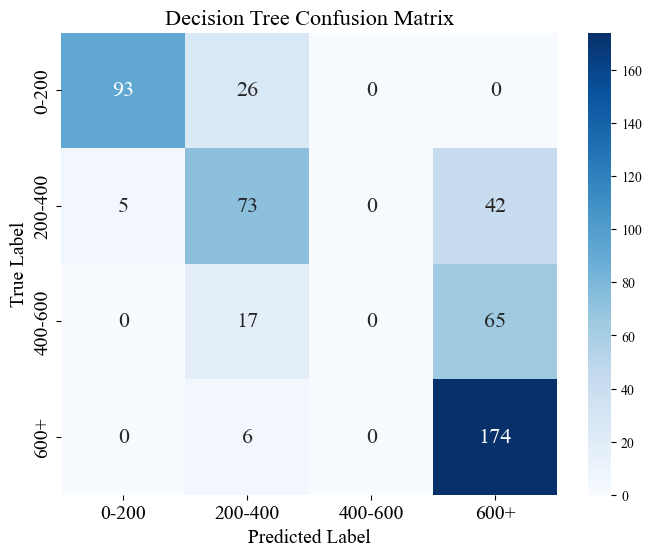

              precision    recall  f1-score   support

       0-200       0.95      0.78      0.86       119
     200-400       0.60      0.61      0.60       120
     400-600       0.00      0.00      0.00        82
        600+       0.62      0.97      0.75       180

    accuracy                           0.68       501
   macro avg       0.54      0.59      0.55       501
weighted avg       0.59      0.68      0.62       501



/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [43]:
config.model_task = "dt_classification"  # Set the model task for Decision Tree
classification_metrics["Decision Tree"] = evaluate_classification_model(config, best_dt_classifier, X_test_flat, y_test_clf, labels=config.labels, 
                                                                          title="Decision Tree Confusion Matrix")

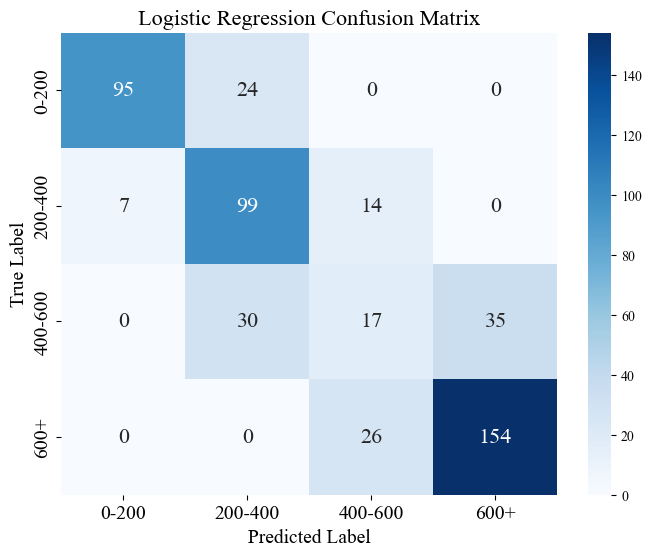

              precision    recall  f1-score   support

       0-200       0.93      0.80      0.86       119
     200-400       0.65      0.82      0.73       120
     400-600       0.30      0.21      0.24        82
        600+       0.81      0.86      0.83       180

    accuracy                           0.73       501
   macro avg       0.67      0.67      0.67       501
weighted avg       0.72      0.73      0.72       501



In [44]:
config.model_task = "lr_classification"  # Set the model task for Logistic Regression
classification_metrics["Logistic Regression"]  = evaluate_classification_model(config, best_lr_classifier, X_test_flat, y_test_clf, labels=config.labels,
                                                         title="Logistic Regression Confusion Matrix")

In [45]:
classification_metrics_df = pd.DataFrame(classification_metrics, index=[
    'Accuarcy', 'Macro F1'
])
classification_metrics_df = classification_metrics_df.T

classification_metrics_df

,Accuarcy,Macro F1
CNN,0.740519,0.706722
Decision Tree,0.678643,0.553832
Logistic Regression,0.728543,0.666074


#### Explanations for Classification models

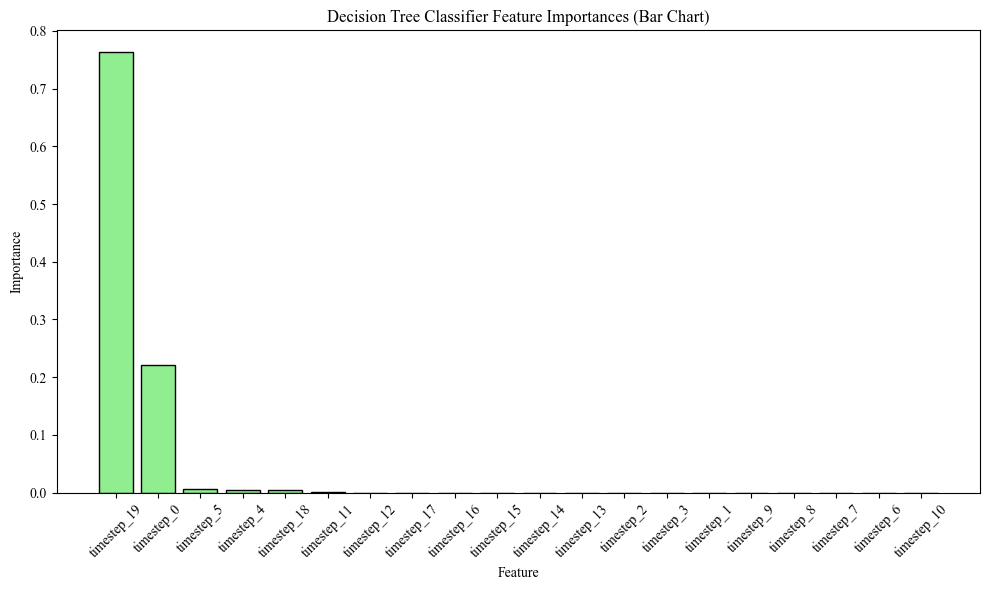

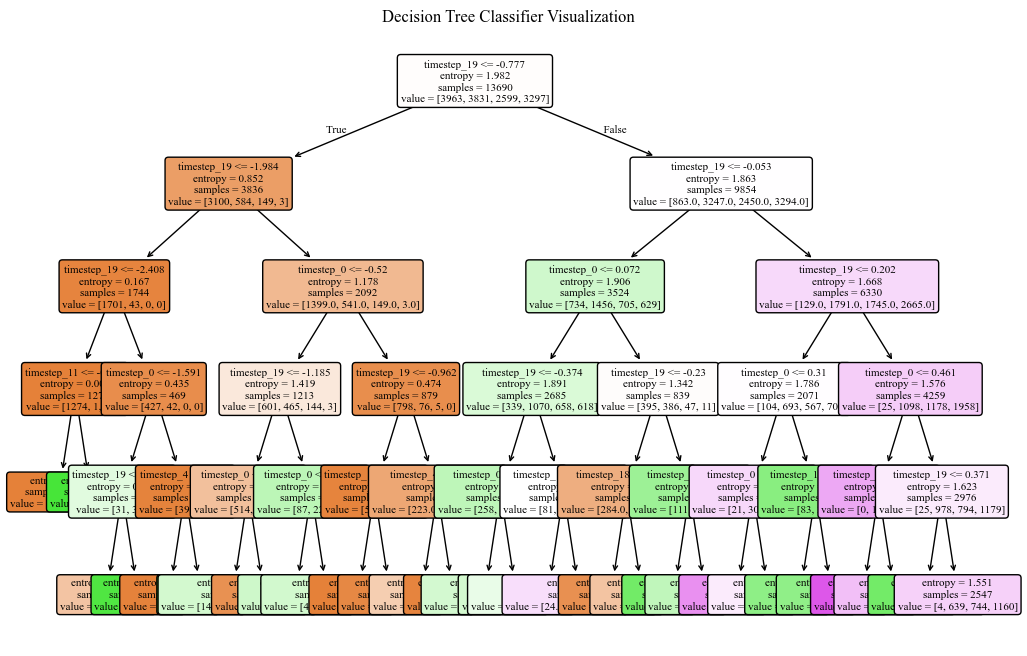

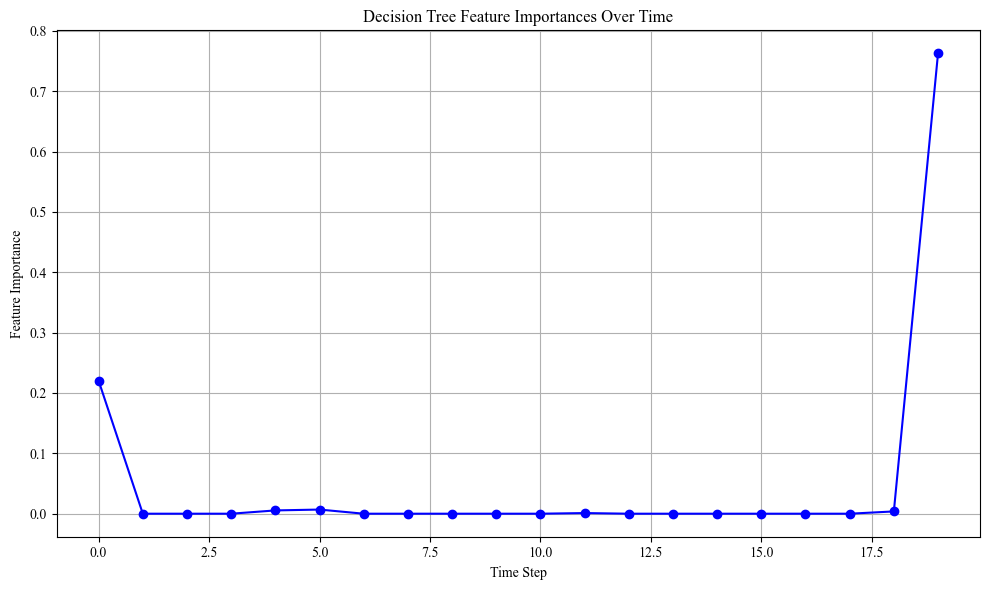

In [46]:
# -------------------------------
# Interpretable Visualizations for Classification Models
# -------------------------------

# Define feature names and timesteps (adjust as needed)
feature_names = [f"timestep_{i}" for i in range(20)]
timesteps = np.array([int(f.split('_')[-1]) for f in feature_names])

# ----- 1. Decision Tree Classifier Visualizations -----

# Bar Chart: Feature Importances
dt_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_dt_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(dt_importances_df['Feature'], dt_importances_df['Importance'],
        color='lightgreen', edgecolor='k')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Decision Tree Classifier Feature Importances (Bar Chart)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Tree Visualization (only feasible for smaller trees)
plt.figure(figsize=(12, 8))
plot_tree(best_dt_classifier, feature_names=feature_names,
          filled=True, rounded=True, fontsize=8)
plt.title("Decision Tree Classifier Visualization")
plt.show()

# Continuous Plot: Feature Importances Over Time
plt.figure(figsize=(10, 6))
plt.plot(timesteps, best_dt_classifier.feature_importances_,
         marker='o', linestyle='-', color='blue')
plt.xlabel("Time Step")
plt.ylabel("Feature Importance")
plt.title("Decision Tree Feature Importances Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


# ----- 2. Logistic Regression Visualizations (Multi-class) -----

# Determine the number of classes from the coefficient array


# Assume best_lr_classifier is already defined and trained
# best_lr_classifier.coef_ has shape (n_classes, n_features)
n_classes = best_lr_classifier.coef_.shape[0]

# Create a combined DataFrame for all classes
data = []
for class_idx in range(n_classes):
    for j, time_step in enumerate(timesteps):
        data.append({
            'Time Step': time_step,
            'Coefficient': best_lr_classifier.coef_[class_idx][j],
            'Class': f"Class {class_idx}"
        })

df_lr = pd.DataFrame(data)

# Create a Plotly Express line plot with markers
fig = px.line(df_lr, x="Time Step", y="Coefficient", color="Class",
              markers=True,
              title="Logistic Regression Coefficients Over Time (All Classes)")
fig.show()



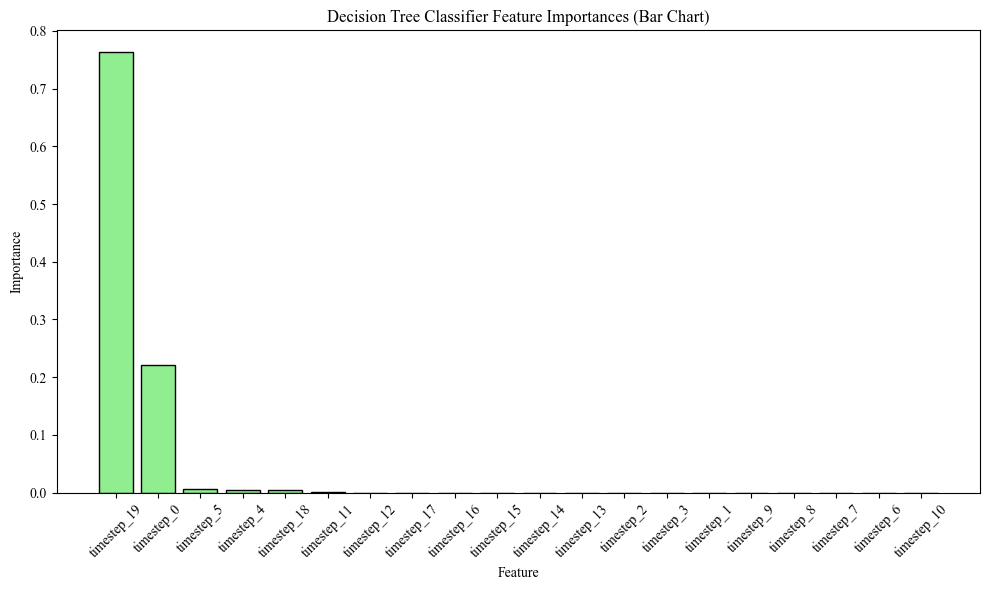

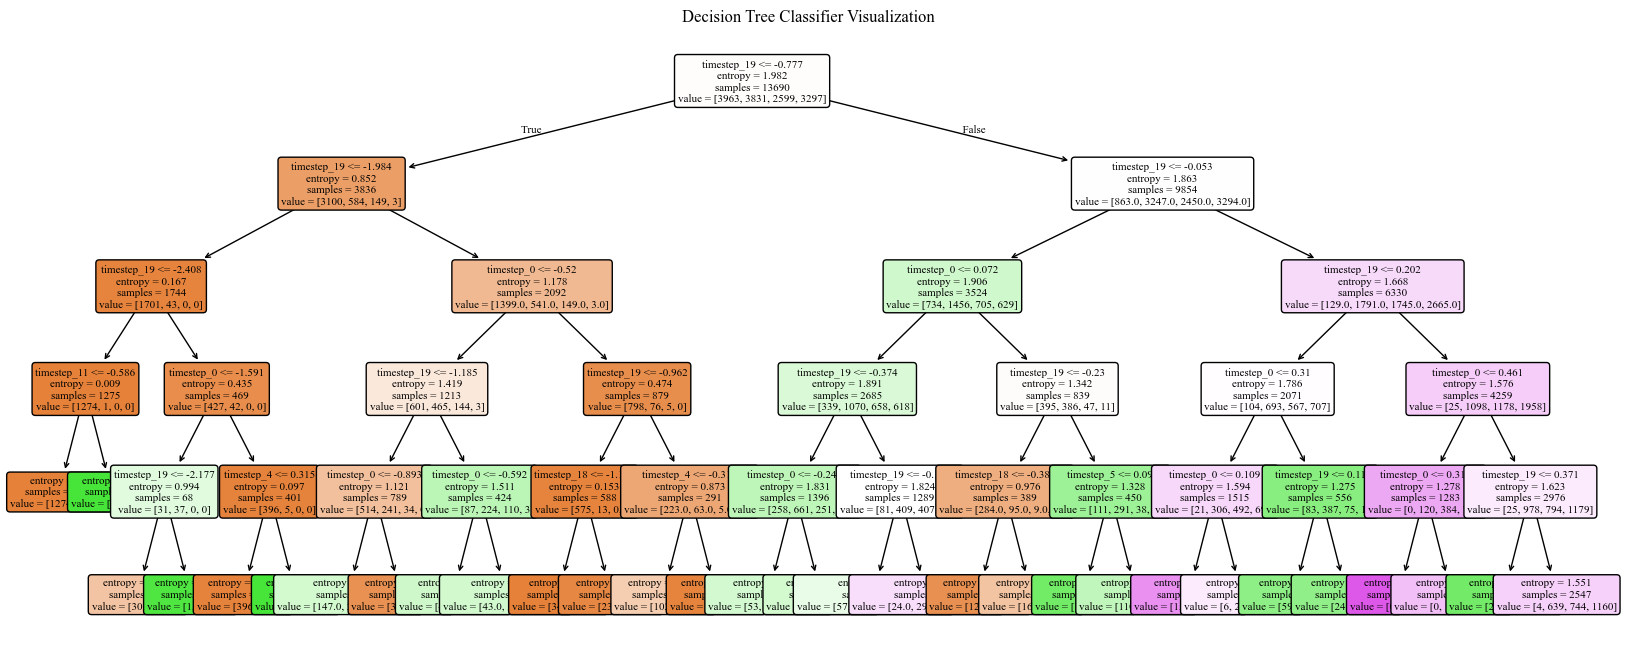

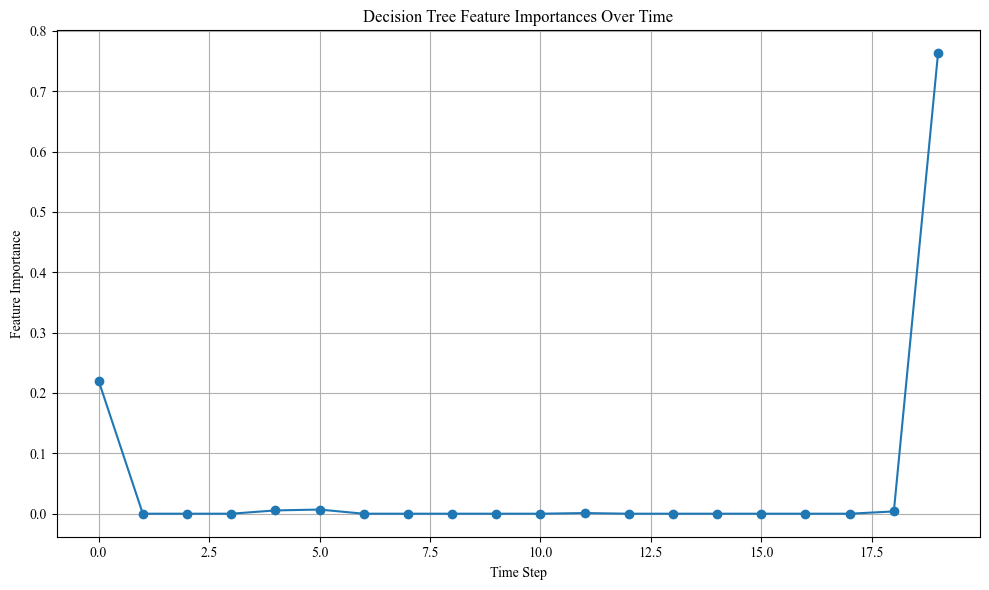

In [47]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import plotly.express as px

# -------------------------------
# Interpretable Visualizations for Classification Models
# -------------------------------

# Define feature names and timesteps (adjust as needed)
feature_names = [f"timestep_{i}" for i in range(20)]
timesteps = np.array([int(f.split('_')[-1]) for f in feature_names])

bottom_map_dir = "aachen" if config.use_aachen else "mit_stanford"
output_dir = os.path.join("experiments", "results", bottom_map_dir)
os.makedirs(output_dir, exist_ok=True)

# ----- 1. Decision Tree Classifier Visualizations -----

config.model_task = "dt_classification"

# Bar Chart: Feature Importances
dt_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_dt_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(dt_importances_df['Feature'], dt_importances_df['Importance'],
        color='lightgreen', edgecolor='k')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Decision Tree Classifier Feature Importances (Bar Chart)")
plt.xticks(rotation=45)
plt.tight_layout()
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f"{config.model_task}_feature_importances_bar_{dataset}_{timestamp}.pdf"
plt.savefig(os.path.join(output_dir, filename), format='pdf', bbox_inches='tight')
plt.show()

# Tree Visualization (only feasible for smaller trees)
plt.figure(figsize=(20, 8))
plot_tree(best_dt_classifier, feature_names=feature_names,
          filled=True, rounded=True, fontsize=8)
plt.title("Decision Tree Classifier Visualization")
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f"{config.model_task}_tree_visualization_{dataset}_{timestamp}.pdf"
plt.savefig(os.path.join(output_dir, filename), format='pdf', bbox_inches='tight')
plt.show()

# Continuous Plot: Feature Importances Over Time
plt.figure(figsize=(10, 6))
plt.plot(timesteps, best_dt_classifier.feature_importances_,
         marker='o', linestyle='-')
plt.xlabel("Time Step")
plt.ylabel("Feature Importance")
plt.title("Decision Tree Feature Importances Over Time")
plt.grid(True)
plt.tight_layout()
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f"{config.model_task}_feature_importances_line_{dataset}_{timestamp}.pdf"
plt.savefig(os.path.join(output_dir, filename), format='pdf', bbox_inches='tight')
plt.show()

# ----- 2. Logistic Regression Visualizations (Multi-class) -----

config.model_task = "logreg_classification"


# Determine the number of classes from the coefficient array
n_classes = best_lr_classifier.coef_.shape[0]

data = []
for class_idx in range(n_classes):
    for j, time_step in enumerate(timesteps):
        data.append({
            'Time Step': time_step,
            'Coefficient': best_lr_classifier.coef_[class_idx][j],
            'Class': f"Class {class_idx}"
        })
df_lr = pd.DataFrame(data)

# Create a Plotly Express line plot with markers
fig = px.line(df_lr, x="Time Step", y="Coefficient", color="Class",
              markers=True,
              title="Logistic Regression Coefficients Over Time (All Classes)")
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f"{config.model_task}_coefficients_line_{dataset}_{timestamp}.pdf"
fig.write_image(os.path.join(output_dir, filename))
fig.show()


## Ante-Hoc Explainability Methods

### Regression

For this section, we will be using the LIME and SHAP libraries to explain the predictions of a regression model. We will use the LSTM model as our baseline and compare the results produced by LIME and SHAP.

In [48]:
# Define a prediction wrapper that converts a 2D input to the model's expected 3D shape.
def predict_wrapper_lstm(X):
    # X is a 2D array of shape (n, n_timesteps); reshape to (n, n_timesteps, 1) for the LSTM model.
    return lstm_model.predict(X.reshape(-1, 20, 1))

#### SHAP

In [49]:
# Sample a background dataset and test set. The larger the background dataset, the more accurate the SHAP values.
background = shap.sample(X_train_flat, 100)

# Initialize the KernelExplainer with the 2D background data and the wrapper function
explainer_shap = shap.KernelExplainer(predict_wrapper_lstm, background)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


##### Local Explanation

In [50]:
# Example: Plot the SHAP values for a single test sample - Local Explanation

# Select one test sample using the SHAP sampler
test_sample = shap.sample(X_test_flat, 1)  # returns a 2D array (1, 20)

# Compute the SHAP values for the sample using the previously defined explainer_shap
shap_values = explainer_shap.shap_values(test_sample)

# Assuming shap_values[0] is a (20, 1) array for a regression output; flatten it to get a 1D array of length 20.
shap_first = shap_values[0].flatten()

# Create a DataFrame for plotting, with a numeric timestep index.
df_shap = pd.DataFrame({
    "timestep_index": np.arange(len(shap_first)),
    "shap_value": shap_first
})

# Create a Plotly bar plot similar to the LIME bar plot.
fig = go.Figure(data=go.Bar(
    x=df_shap["timestep_index"],
    y=df_shap["shap_value"],
    marker_color="teal"  # you can choose any color you like
))
fig.update_layout(
    title="SHAP Explanation by Timestep",
    xaxis_title="Timestep Index",
    yaxis_title="SHAP Value",
    xaxis=dict(tickmode="linear", dtick=1)  # show every timestep
)
fig.show()


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


##### Global Explanation

In [51]:
# This cell reshapes the test data, samples a subset, computes SHAP values for the sampled test set,
# and calculates both the mean (signed) and mean absolute SHAP values per timestep.

# Reshape X_test to 2D (n_test, n_timesteps)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Sample a subset of test data (e.g., 200 samples) for efficiency
X_test_shap = shap.sample(X_test_flat, 200, random_state=1)

# Compute SHAP values for the sampled test set
shap_values = explainer_shap.shap_values(X_test_shap)
if isinstance(shap_values, list):
    shap_values = shap_values[0]  # Now shap_values has shape (200, n_timesteps)

# Compute the mean (signed) SHAP value per timestep across the sampled test set
mean_shap = np.mean(shap_values, axis=0)[:,0]  # shape: (n_timesteps,)

# Compute the mean absolute SHAP value per timestep across the sampled test set
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)[:,0]  # shape: (n_timesteps,)


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 7s 998us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 976us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 984us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 984us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 981us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 7s 998us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 981us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 7s 1000us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 994us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━

KeyboardInterrupt: 

In [ ]:
# This plots the global explanation using the mean SHAP values, and the mean absolute SHAP values.

# Create a DataFrame for plotting, with a numeric timestep index.
df_shap = pd.DataFrame({
    "timestep_index": np.arange(len(mean_shap)),
    "shap_value": mean_shap
})

# Create a Plotly bar plot similar to the LIME bar plot.
fig = go.Figure(data=go.Bar(
    x=df_shap["timestep_index"],
    y=df_shap["shap_value"],
    marker_color="teal"
))
fig.update_layout(
    title="Global SHAP Explanation by Timestep",
    xaxis_title="Timestep Index",
    yaxis_title="SHAP Value",
    xaxis=dict(tickmode="linear", dtick=1)  # show every timestep
)
fig.show()



# Create a DataFrame for plotting, with a numeric timestep index.
df_shap = pd.DataFrame({
    "timestep_index": np.arange(len(mean_shap)),
    "shap_value": mean_abs_shap
})

# Create a Plotly bar plot similar to the LIME bar plot.
fig = go.Figure(data=go.Bar(
    x=df_shap["timestep_index"],
    y=df_shap["shap_value"],
    marker_color="teal"
))
fig.update_layout(
    title="Global Absolute SHAP Explanation by Timestep",
    xaxis_title="Timestep Index",
    yaxis_title="SHAP Value",
    xaxis=dict(tickmode="linear", dtick=1)  # show every timestep
)
fig.show()



: 

: 

: 

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px

# Assume shap_values is computed earlier and has shape (200, n_timesteps)
# For example, from:
# shap_values = explainer_shap.shap_values(X_test_shap)
# if isinstance(shap_values, list):
#     shap_values = shap_values[0]

n_samples, n_timesteps, _ = shap_values.shape

# Unroll the matrix to a long-form DataFrame.
df_beeswarm = pd.DataFrame({
    "timestep": np.repeat(np.arange(n_timesteps), n_samples),
    "shap_value": shap_values.flatten()
})

# Add a small jitter to the timestep values so that points don't all stack on top of each other.
jitter = np.random.uniform(-0.3, 0.3, size=df_beeswarm.shape[0])
df_beeswarm["timestep_jitter"] = df_beeswarm["timestep"] + jitter

# Create the beeswarm plot using Plotly Express.
fig = px.scatter(
    df_beeswarm,
    x="timestep_jitter",
    y="shap_value",
    title="Global SHAP Beeswarm Plot by Timestep",
    labels={"timestep_jitter": "Timestep", "shap_value": "SHAP Value"},
    opacity=0.7
)

# Adjust marker size and x-axis ticks.
fig.update_traces(marker=dict(size=5))
fig.update_layout(
    xaxis=dict(tickmode="linear", dtick=1),
    height=800
)

fig.show()


: 

: 

: 

#### LIME

In [52]:
# Initialize the LIME explainer for regression.
explainer_lime = LimeTabularExplainer(
    training_data=X_train_flat,
    feature_names=feature_names,
    mode='regression',
    discretize_continuous=True
)

##### Local Explanation

Lime's explanations can't be aggregated to a global explanation, but we can use the local explanations to understand the model's behavior for a specific instance.

In [53]:
# Example: Select a single instance from the test set for explanation.

instance = X_test_flat[0]  # A 1D vector of shape (n_timesteps,)

# Generate a LIME explanation for the selected instance.
# 'num_features' controls how many timesteps (features) will be shown in the explanation.
explanation = explainer_lime.explain_instance(instance, predict_wrapper_lstm, num_features=20)

# Get the LIME explanation as a list of tuples:
lime_explanation_list = explanation.as_list()  # e.g., [("timestep_0", 0.12), ("timestep_1", -0.05), ...]

# Convert to DataFrame:
df_lime = pd.DataFrame(lime_explanation_list, columns=["feature", "contribution"])

# Extract numeric timestep index from the feature names, assuming they follow "timestep_<number>"
df_lime["timestep_index"] = df_lime["feature"].str.extract("timestep_(\d+)").astype(int)

# Now create a Plotly bar plot using the numeric x-axis.
fig = go.Figure(data=go.Bar(
    x=df_lime["timestep_index"],
    y=df_lime["contribution"],
    marker_color="teal"
))
fig.update_layout(
    title="LIME Explanation by Timestep",
    xaxis_title="Timestep Index",
    yaxis_title="Contribution",
    xaxis=dict(tickmode="linear", dtick=1)  # dtick=10 will show ticks every 10 timesteps
)
fig.show()


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


#### Comparing Ante-Hoc Explainability Methods for Regression

In [54]:
# Function to explain and plot SHAP + LIME for a given sample

def explain_and_plot_shap_lime(sample_2d, sample_index, label, y_true, y_pred):
    """
    Compute SHAP + LIME values for a single sample, then make
    one grouped bar chart (SHAP vs. LIME) across timesteps.
    """

    # ~~~~~ SHAP Explanation ~~~~~
    sample_2d_reshaped = sample_2d.reshape(1, -1)
    shap_values_single = explainer_shap.shap_values(sample_2d_reshaped, silent=True)
    shap_values_single = shap_values_single[0].flatten()  # shape (n_timesteps,)

    df_shap = pd.DataFrame({
        "timestep_index": np.arange(len(shap_values_single)),
        "shap_value": shap_values_single
    })

    # ~~~~~ LIME Explanation ~~~~~
    lime_explanation = explainer_lime.explain_instance(
        sample_2d,
        predict_wrapper_lstm,     # Use the same wrapper
        num_features=n_timesteps
    )
    lime_explanation_list = lime_explanation.as_list()  # [(feature_name, contribution), ...]
    df_lime = pd.DataFrame(lime_explanation_list, columns=["feature", "contribution"])

    # If features are named like "timestep_0", extract the numeric index:
    df_lime["timestep_index"] = df_lime["feature"].str.extract("timestep_(\d+)").astype(int)
    df_lime = df_lime.sort_values("timestep_index")

    # ~~~~~ Merge Both into One DataFrame ~~~~~
    df_combined = pd.merge(
        df_shap, 
        df_lime[["timestep_index", "contribution"]], 
        on="timestep_index",
        how="inner"
    ).rename(columns={"shap_value": "shap_value", "contribution": "lime_contribution"})
    # Now we have: [timestep_index, shap_value, lime_contribution]

    # ~~~~~ Plotly Grouped Bar Chart ~~~~~
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=df_combined["timestep_index"],
        y=df_combined["shap_value"],
        name="SHAP Value"
    ))
    fig.add_trace(go.Bar(
        x=df_combined["timestep_index"],
        y=df_combined["lime_contribution"],
        name="LIME Contribution"
    ))
    fig.update_layout(
        barmode='group',
        title=f"SHAP + LIME (Sample #{sample_index})<br>"
              f"Label: {label} | True: {y_true:.4f} | Pred: {y_pred:.4f}",
        xaxis_title="Timestep Index",
        yaxis_title="Value",
        xaxis=dict(tickmode="linear", dtick=10)
    )
    fig.show()

In [55]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def explain_and_plot_shap_lime(sample_2d, sample_index, label, y_true, y_pred, index = ""):
    """
    Compute SHAP and LIME explanations for a single sample, then produce a subplot figure:
      - Row 1: A line plot of the raw input sample over timesteps.
      - Row 2: A grouped bar chart comparing SHAP and LIME contributions.
    
    Parameters:
        sample_2d (np.array): 1D array (length n_timesteps) representing the sample.
        sample_index (int): Index of the sample.
        label (str): Label for the sample (e.g., "p25", "p50", etc.).
        y_true (float): True target value.
        y_pred (float): Predicted target value.
    """
    # ~~~~~ SHAP Explanation ~~~~~
    sample_reshaped = sample_2d.reshape(1, -1)
    shap_values_single = explainer_shap.shap_values(sample_reshaped, silent=True)
    if isinstance(shap_values_single, list):
        shap_values_single = shap_values_single[0]
    shap_values_single = shap_values_single.flatten()  # shape: (n_timesteps,)
    
    df_shap = pd.DataFrame({
        "timestep_index": np.arange(len(shap_values_single)),
        "shap_value": shap_values_single
    })
    
    # ~~~~~ LIME Explanation ~~~~~
    lime_explanation = explainer_lime.explain_instance(
        sample_2d,
        predict_wrapper_lstm,  # Use the same prediction wrapper
        num_features=n_timesteps
    )
    lime_explanation_list = lime_explanation.as_list()
    df_lime = pd.DataFrame(lime_explanation_list, columns=["feature", "contribution"])
    df_lime["timestep_index"] = df_lime["feature"].str.extract("timestep_(\d+)").astype(int)
    df_lime = df_lime.sort_values("timestep_index")
    
    # ~~~~~ Merge SHAP and LIME Data ~~~~~
    df_combined = pd.merge(
        df_shap, 
        df_lime[["timestep_index", "contribution"]],
        on="timestep_index",
        how="inner"
    ).rename(columns={"contribution": "lime_contribution"})
    
    # ~~~~~ Create Subplots ~~~~~
    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.15,
        subplot_titles=(
            f"Observed Time Series Data (Sample #{sample_index})<br>"
            f"Label: {label} | True: {y_true:.4f} | Pred: {y_pred:.4f}",
            "Feature Contribution Comparison (SHAP vs. LIME)"
        )
    )
    
    # Row 1: Plot the raw input sample as a line chart.
    fig.add_trace(
        go.Scatter(
            x=np.arange(len(sample_2d)),
            y=sample_2d,
            mode='lines+markers',
            name="Input Sample"
        ),
        row=1, col=1
    )
    
    # Add y-axis title for row 1.
    fig.update_yaxes(title_text="Input Value", row=1, col=1)
    
    # Row 2: Plot SHAP values as a bar chart.
    fig.add_trace(
        go.Bar(
            x=df_combined["timestep_index"],
            y=df_combined["shap_value"],
            name="SHAP Value"
        ),
        row=2, col=1
    )
    
    # Row 2: Plot LIME contributions as a bar chart.
    fig.add_trace(
        go.Bar(
            x=df_combined["timestep_index"],
            y=df_combined["lime_contribution"],
            name="LIME Contribution"
        ),
        row=2, col=1
    )
    
    # Update layout: Set an overall title and move the legend to the right.
    fig.update_layout(
        title=dict(
            text="Time Series Interpretability: Input & Explanation Analysis",
            x=0.5,
            xanchor="center",
            font=dict(size=24)
        ),
        barmode='group',
        xaxis2_title="Timestep Index",
        yaxis2_title="Contribution",
        xaxis=dict(tickmode="linear", dtick=1),
        height=800,
        legend=dict(
            orientation="v",
            x=1.02,
            y=1,
            font=dict(size=14)
        )
    )

    # Save the figure as a PDF file in the specified directory.
    dataset = "aachen" if config.use_aachen else "mit_stanford"

    fig.write_image(f"experiments/results_XAI/{dataset}/Local_Explanation_Regression_{label}_{index}_{dataset}.pdf", engine="kaleido")

    
    fig.show()


##### How does the explanations change for different percentiles of the target variable?

This subsection will explore how the explanations change for different percentiles of the target variable. We will use the SHAP and LIME libraries to explain the predictions of a regression model.

In [56]:
# ===============================================
# Looking at how SHAP and LIME values compare for samples for different values of the target variable
# ===============================================
# The purpose of this section is to show how the predictions change for samples with different target values.
# We will pick samples at different percentiles of the target variable, then compare SHAP and LIME explanations.

y_pred_lstm = lstm_model.predict(X_test_flat.reshape(-1, 20, 1), verbose=False).flatten()

# =======================================
# 1) Pick Interesting Samples (Percentiles)
# =======================================
sorted_indices = np.argsort(y_test_reg) 
n_samples = len(y_test_reg)

p0_index   = sorted_indices[0]
p25_index  = sorted_indices[int(0.25 * n_samples)]
p50_index  = sorted_indices[int(0.50 * n_samples)]
p75_index  = sorted_indices[int(0.75 * n_samples)]
p100_index = sorted_indices[-1]

percentile_indices = {
    "p0 (Lowest)": p0_index,
    "p25": p25_index,
    "p50": p50_index,
    "p75": p75_index,
    "p100 (Highest)": p100_index
}

print("Percentile sample indices based on true values:")
for label, idx in percentile_indices.items():
    print(f"{label}: index {idx}, "
          f"prediction {y_test_reg[idx]:.4f}, "
          f"true {y_pred_lstm[idx]:.4f}")


# =======================================
# 2) Generate Combined Plots using the explain_and_plot_shap_lime function.
# =======================================
for label, idx in percentile_indices.items():
    sample_2d = X_test_flat[idx]  # shape: (n_timesteps,)
    true_val  = y_test_reg[idx]
    pred_val  = y_pred_lstm[idx]
    
    explain_and_plot_shap_lime(
        sample_2d=sample_2d,
        sample_index=idx,
        label=label,
        y_true=true_val,
        y_pred=pred_val
    )

Percentile sample indices based on true values:
p0 (Lowest): index 500, prediction 0.0000, true 0.0215
p25: index 376, prediction 0.1148, true 0.1047
p50: index 142, prediction 0.2301, true 0.3188
p75: index 271, prediction 0.4004, true 0.2977
p100 (Highest): index 0, prediction 0.6143, true 0.3358
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
 447/6525 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step

KeyboardInterrupt: 

##### Sampling a representative subset of the data using K-Means clustering

In [90]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np

# Assume X_test_flat is your test data reshaped to 2D (n_test, n_timesteps)
# and y_test_reg contains the corresponding true target values.
# Set the number of clusters (e.g., 10 representative samples)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_test_flat)
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

# For each cluster, choose the sample that is closest to the cluster center.
selected_indices = []
for i in range(n_clusters):
    indices_in_cluster = np.where(cluster_labels == i)[0]
    if len(indices_in_cluster) == 0:
        continue
    # Compute distances from samples in the cluster to the cluster center.
    distances = cdist(X_test_flat[indices_in_cluster], cluster_centers[i].reshape(1, -1), metric='euclidean').flatten()
    best_index = indices_in_cluster[np.argmin(distances)]
    selected_indices.append(best_index)

print("Selected sample indices from KMeans clustering:", selected_indices)

index = 1

# Now loop over the selected indices and generate explanations for each sample.
for idx in selected_indices:
    sample_2d = X_test_flat[idx]  # shape: (n_timesteps,)
    true_val  = y_test_reg[idx]
    # Get the prediction; adjust reshape if needed for your model.
    pred_val  = lstm_model.predict(X_test_flat[idx].reshape(1, -1, 1), verbose=False).flatten()[0]
    
    explain_and_plot_shap_lime(
        sample_2d=sample_2d,
        sample_index=idx,
        label="Cluster Sample",
        y_true=true_val,
        y_pred=pred_val,
        index=str(index)  # Use the index for naming
    )

    index += 1

    



f"experiments/results_XAI/mit_stanford/Local_Explanation_Regression_Cluster_{j+1}_mit_stanford.pdf"


Selected sample indices from KMeans clustering: [368, 297, 414, 380, 351, 397, 15, 406, 328, 390]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 451us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/lime/lime_tabular.py:372: UserWarning:


                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    



IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:


# =======================================
# 4) Generate Combined Plots for the Spike Samples
# =======================================
# Assuming 'X_test_flat' (shape: (n_samples, n_timesteps)) and 'y_test_reg' are defined,
# and that 'lstm_model' is loaded, along with SHAP and LIME explainers.
y_pred_lstm = lstm_model.predict(X_test_flat.reshape(-1, 20, 1)).flatten()

# Compute a spike score for each sample: maximum absolute difference between consecutive timesteps.
spike_scores = np.max(np.abs(np.diff(X_test_flat, axis=1)), axis=1)

# Get indices of the top 3 samples with highest spike scores.
top3_indices = np.argsort(spike_scores)[-3:][::-1]

print("Top 3 samples with highest spike scores:")
for idx in top3_indices:
    print(f"Index {idx}: Spike score = {spike_scores[idx]:.4f}, Prediction = {y_pred_lstm[idx]:.4f}, True = {y_test_reg[idx]:.4f}")

for idx in top3_indices:
    sample_2d = X_test_flat[idx]  # shape: (n_timesteps,)
    true_val  = y_test_reg[idx]
    pred_val  = y_pred_lstm[idx]
    label = f"Spike Score: {spike_scores[idx]:.4f}"
    
    explain_and_plot_shap_lime(
        sample_2d=sample_2d,
        sample_index=idx,
        label=label,
        y_true=true_val,
        y_pred=pred_val
    )


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Top 3 samples with highest spike scores:
Index 389: Spike score = 0.2309, Prediction = 0.0511, True = 0.0794
Index 395: Spike score = 0.2309, Prediction = 0.0748, True = 0.0631
Index 387: Spike score = 0.2309, Prediction = 0.1106, True = 0.0849
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 883us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 895us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 895us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# Define the sample index we want to plot from the training set
sample_index = 13080

# Extract sample 14814 from X_train
sample_2d = X_train[sample_index]
# If the sample has shape (n_timesteps, 1), squeeze it to shape (n_timesteps,)
if sample_2d.ndim == 2 and sample_2d.shape[1] == 1:
    sample_2d = sample_2d.squeeze(axis=-1)

# Get the true value for this sample from y_train.
# Adjust if y_train is multidimensional (e.g., (n_samples, 1))
true_val = y_train_reg[sample_index]
if isinstance(true_val, np.ndarray):
    true_val = true_val.item()

# Compute the predicted value using the model.
# lstm_model expects input shape (1, n_timesteps, 1), so reshape accordingly.
pred_val = lstm_model.predict(sample_2d.reshape(1, -1, 1)).flatten()[0]

# Create a label for the plot
label = f"Sample {sample_index} from Training Set"

# Now call the explanation and plotting function to generate the combined plot.
explain_and_plot_shap_lime(
    sample_2d=sample_2d,
    sample_index=sample_index,
    label=label,
    y_true=true_val,
    y_pred=pred_val
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 884us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:


# --------------------------
# Function: Compute Top-K Overlap
# --------------------------
def compute_top_k_overlap(sample_2d, k=10):
    """
    For a given sample (a 1D array of length n_timesteps), compute:
      - Top-k features (timesteps) from SHAP (based on absolute SHAP values)
      - Top-k features (timesteps) from LIME (based on absolute contribution)
      - The overlap between these two sets.
      
    Returns:
      top_k_shap: Sorted list (ascending) of top-k timestep indices from SHAP.
      top_k_lime: Sorted list (descending by absolute value) of top-k timestep indices from LIME.
      overlap: Number of overlapping features.
      overlap_ratio: Overlap divided by k.
    """
    # ---- SHAP Explanation ----
    sample_reshaped = sample_2d.reshape(1, -1)
    shap_values_sample = explainer_shap.shap_values(sample_reshaped)
    # If returned as list, extract first element for single-output model:
    if isinstance(shap_values_sample, list):
        shap_values_sample = shap_values_sample[0]
    # Flatten to 1D array of shape (n_timesteps,)
    shap_values_sample = shap_values_sample.flatten()
    
    # Get top-k indices for SHAP (largest absolute values)
    top_k_shap = np.argsort(np.abs(shap_values_sample))[-k:]
    
    # ---- LIME Explanation ----
    lime_explanation = explainer_lime.explain_instance(
        sample_2d,
        predict_wrapper_lstm,     # same wrapper used for SHAP
        num_features=n_timesteps
    )
    lime_explanation_list = lime_explanation.as_list()  # list of (feature, contribution)
    df_lime = pd.DataFrame(lime_explanation_list, columns=["feature", "contribution"])
    
    # Extract numeric timestep index from feature names (assuming "timestep_N")
    df_lime["timestep_index"] = df_lime["feature"].str.extract("timestep_(\d+)").astype(int)
    # Compute absolute contribution for sorting
    df_lime["abs_contribution"] = df_lime["contribution"].abs()
    # Get top-k indices for LIME (largest absolute contribution)
    top_k_lime = df_lime.sort_values("abs_contribution", ascending=False).head(k)["timestep_index"].values
    
    # ---- Compute Overlap ----
    overlap = len(set(top_k_shap).intersection(set(top_k_lime)))
    overlap_ratio = overlap / k
    
    return top_k_shap, top_k_lime, overlap, overlap_ratio

# --------------------------
# Example: Top-K Analysis on Percentile Samples
# --------------------------
# Assume y_pred_lstm (or y_test_reg) and percentile_indices are already computed.
# Here we use the percentile_indices from your previous code.
# For example, suppose:
# percentile_indices = {
#     "p0 (Lowest)": p0_index,
#     "p25": p25_index,
#     "p50": p50_index,
#     "p75": p75_index,
#     "p100 (Highest)": p100_index
# }

k = 5  # Change k to how many top features you want to compare

print("Top-K Analysis (k = {}):".format(k))
for label, idx in percentile_indices.items():
    sample_2d = X_test_flat[idx]  # sample of shape (n_timesteps,)
    top_k_shap, top_k_lime, overlap, overlap_ratio = compute_top_k_overlap(sample_2d, k)
    
    print(f"\nSample Label: {label} (Index {idx})")
    print(f"  Top-{k} SHAP timesteps: {np.sort(top_k_shap)}")
    print(f"  Top-{k} LIME timesteps: {np.sort(top_k_lime)}")
    print(f"  Overlap: {overlap} / {k} (Overlap Ratio: {overlap_ratio:.2f})")


Top-K Analysis (k = 5):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 884us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Sample Label: p0 (Lowest) (Index 500)
  Top-5 SHAP timesteps: [12 14 17 18 19]
  Top-5 LIME timesteps: [ 5 14 17 18 19]
  Overlap: 4 / 5 (Overlap Ratio: 0.80)


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 882us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Sample Label: p25 (Index 376)
  Top-5 SHAP timesteps: [15 16 17 18 19]
  Top-5 LIME timesteps: [13 15 17 18 19]
  Overlap: 4 / 5 (Overlap Ratio: 0.80)


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 897us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Sample Label: p50 (Index 142)
  Top-5 SHAP timesteps: [13 14 17 18 19]
  Top-5 LIME timesteps: [ 5  8 12 16 19]
  Overlap: 1 / 5 (Overlap Ratio: 0.20)


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 893us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Sample Label: p75 (Index 271)
  Top-5 SHAP timesteps: [ 6  8 14 18 19]
  Top-5 LIME timesteps: [ 5 14 17 18 19]
  Overlap: 3 / 5 (Overlap Ratio: 0.60)


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 896us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Sample Label: p100 (Highest) (Index 0)
  Top-5 SHAP timesteps: [13 14 15 18 19]
  Top-5 LIME timesteps: [10 12 17 18 19]
  Overlap: 2 / 5 (Overlap Ratio: 0.40)


### Classification

In [57]:
# Create a wrapper for the CNN model's predict function.
# Adjust the reshape dimensions (here, assuming n_timesteps timesteps and 1 channel)
def predict_wrapper_cnn(X):
    # Reshape X from (n, n_timesteps) to (n, n_timesteps, 1)
    return cnn_model.predict(X.reshape(-1, 20, 1))

#### SHAP

In [58]:
# Sample a background dataset (using 100 samples here)
background = shap.sample(X_train_flat, 100)

# Initialize the SHAP KernelExplainer with the wrapper and background data.
explainer_shap = shap.KernelExplainer(predict_wrapper_cnn, background)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


##### Local Explanation

In [59]:
def plot_shap_and_sample(sample_idx):
    # Get the sample from the original (unshuffled) test set.
    X_sample = X_test[sample_idx:sample_idx+1]  # Shape may be (1, timesteps, ...) 
    y_sample = y_test_clf[sample_idx]  # One-hot encoded true label
    
    # Convert one-hot encoded true label to index.
    true_idx = np.argmax(y_sample) if isinstance(y_sample, np.ndarray) and y_sample.ndim > 0 else y_sample

    # Use the original sample shape for prediction.
    pred = cnn_model.predict(X_sample)
    predicted_idx = np.argmax(pred)
    predicted_confidence = pred[0, predicted_idx]
    
    # Map predicted and true indices to class labels.
    if 'classification_labels' in globals() and len(classification_labels) > predicted_idx:
        predicted_class = classification_labels[predicted_idx]
        true_class = classification_labels[true_idx]
    else:
        predicted_class = predicted_idx
        true_class = true_idx

    # Compute SHAP values.
    # If your explainer was built on flattened data, flatten the sample accordingly.
    X_sample_flat = X_sample.reshape(1, -1)
    # Your SHAP explainer returns an array of shape (1, n_features, n_classes)
    shap_values_local_all = explainer_shap.shap_values(X_sample_flat)
    sample_shap = shap_values_local_all[0]  # Shape: (n_features, n_classes)
    
    n_features = sample_shap.shape[0]
    n_classes = sample_shap.shape[1]
    
    # Use classification_labels if available.
    if 'classification_labels' in globals() and len(classification_labels) == n_classes:
        class_names = classification_labels
    else:
        class_names = [f"Class {i}" for i in range(n_classes)]
    
    # Prepare a DataFrame for plotting SHAP values: one row per feature per class.
    data_shap = []
    for class_idx in range(n_classes):
        for feature_idx in range(n_features):
            data_shap.append({
                "Feature": feature_idx,
                "SHAP Value": sample_shap[feature_idx, class_idx],
                "Class": class_names[class_idx]
            })
    df_shap = pd.DataFrame(data_shap)
    
    # Create the SHAP explanation plot.
    title_shap = (f"SHAP Explanation for Sample {sample_idx} | "
                  f"True: {true_class}, Predicted: {predicted_class} (Confidence: {predicted_confidence:.2f})")
    fig_shap = px.line(df_shap,
                       x="Feature",
                       y="SHAP Value",
                       color="Class",
                       markers=True,
                       title=title_shap)
    fig_shap.update_layout(xaxis=dict(dtick=1))
    
    # Build the input sample plot.
    # Squeeze in case the sample has extra dimensions.
    sample_input = X_sample.squeeze()
    df_sample = pd.DataFrame({
        "Feature": np.arange(len(sample_input)),
        "Value": sample_input
    })
    fig_sample = px.line(df_sample,
                         x="Feature",
                         y="Value",
                         markers=True,
                         title=f"Input Sample {sample_idx}")
    fig_sample.update_layout(xaxis=dict(dtick=1))
    
    # Combine both plots into one figure using subplots.
    combined_fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.15,
        subplot_titles=(title_shap, f"Input Sample {sample_idx}")
    )
    
    for trace in fig_shap.data:
        combined_fig.add_trace(trace, row=1, col=1)
    for trace in fig_sample.data:
        combined_fig.add_trace(trace, row=2, col=1)
    
    combined_fig.update_layout(height=800, xaxis=dict(dtick=1))
    return combined_fig

# Change sample_idx to any valid index.
sample_idx = 311  # For example
fig = plot_shap_and_sample(sample_idx)
fig.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 491us/step


##### Global Explanation

In [70]:
# Global SHAP Calculation

# This cell shuffles the test set, computes SHAP values for the first 50 samples, and aggregates the mean absolute SHAP values per feature(timestep)
# for a multiclass problem (resulting in a matrix of shape (n_features, n_classes)).

# Reshape X_test to 2D (n_test, n_timesteps)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Shuffle the test set so that the order is random.
indices = np.arange(X_test.shape[0])
np.random.shuffle(indices)
X_test_shuffled = X_test[indices]
y_test_clf_shuffled = y_test_clf[indices]

# Reshape X_test_shuffled for SHAP evaluation (if needed)
X_test_shuffled_2d = X_test_shuffled.reshape(X_test_shuffled.shape[0], -1)

# Compute SHAP values for the first 50 samples of the shuffled test set.
# In multiclass classification, shap_values is usually returned as a list with one array per class.
shap_values = explainer_shap.shap_values(X_test_shuffled_2d[:50])
if isinstance(shap_values, list):
    shap_values = shap_values[0]  # Now shap_values has shape: (50, n_timestepsimesteps)

# Compute the mean absolute SHAP values per feature across these 50 samples.
# This results in a matrix of shape (n_timesteps, num_classes)
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)  # shape: (n_timestepsimesteps, num_classes)

print("Global mean absolute SHAP values shape:", mean_abs_shap.shape)


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 496us/step


KeyboardInterrupt: 

In [ ]:
# Global SHAP Plotting - Mean Absolute SHAP Values
# This cell uses the aggregated global SHAP explanation computed in the previous cell to plot a line chart
# showing the mean absolute SHAP values by feature (timestep) for each class.

# Determine the number of features and classes from mean_abs_shap.
num_features = mean_abs_shap.shape[0]  # Expected to be n_timesteps.
num_classes = mean_abs_shap.shape[1]   # Expected to be the number of classes (e.g., 7).

# Ensure that classification_labels has the expected length.
if len(classification_labels) != num_classes:
    print("Warning: classification_labels length does not match number of classes. Using fallback names.")
    class_names = [f"Class {i}" for i in range(num_classes)]
else:
    class_names = classification_labels

# Prepare a DataFrame for plotting.
# Each row corresponds to one feature (timestep) for a particular class.
data = []
for feature_idx in range(num_features):
    for class_idx in range(num_classes):
        data.append({
            "Feature": feature_idx,  # Numeric x-axis value.
            "Mean Absolute SHAP Value": mean_abs_shap[feature_idx, class_idx],
            "Class": class_names[class_idx]
        })

df_shap = pd.DataFrame(data)

# Create a line plot with Plotly Express.
fig = px.line(df_shap, 
              x="Feature", 
              y="Mean Absolute SHAP Value", 
              color="Class", 
              markers=True,
              title="Global Explanation: Mean Absolute SHAP Values")

fig.update_layout(
    xaxis_title="Time Step",
    yaxis_title="Mean Absolute SHAP Value",
    xaxis=dict(tickmode="linear", dtick=1),  # Adjust dtick as needed.
    height=800
)

fig.show()


In [ ]:
# Global SHAP Plotting - Mean SHAP Values

# This cell uses the aggregated global SHAP explanation computed in the previous cell to plot a line chart
# showing the mean absolute SHAP values by feature (timestep) for each class.

mean_shap = np.mean(shap_values, axis=0)  # shape: (n_timestepsimesteps, num_classes)


# Determine the number of features and classes from mean_abs_shap.
num_features = mean_shap.shape[0]  # Expected to be n_timesteps.
num_classes = mean_shap.shape[1]   # Expected to be the number of classes (e.g., 7).

# Ensure that classification_labels has the expected length.
if len(classification_labels) != num_classes:
    print("Warning: classification_labels length does not match number of classes. Using fallback names.")
    class_names = [f"Class {i}" for i in range(num_classes)]
else:
    class_names = classification_labels

# Prepare a DataFrame for plotting.
# Each row corresponds to one feature (timestep) for a particular class.
data = []
for feature_idx in range(num_features):
    for class_idx in range(num_classes):
        data.append({
            "Feature": feature_idx,  # Numeric x-axis value.
            "Mean SHAP Value": mean_shap[feature_idx, class_idx],
            "Class": class_names[class_idx]
        })

df_shap = pd.DataFrame(data)

# Create a line plot with Plotly Express.
fig = px.line(df_shap, 
              x="Feature", 
              y="Mean SHAP Value", 
              color="Class", 
              markers=True,
              title="Global Explanation: Mean SHAP Values by Feature and Class")

fig.update_layout(
    xaxis_title="Time Step",
    yaxis_title="Mean Absolute SHAP Value",
    xaxis=dict(tickmode="linear", dtick=1),  # Adjust dtick as needed.
    height=800
)

fig.show()


#### Lime

##### Local Explanation

In [71]:
explainer_lime = LimeTabularExplainer(
    training_data=X_train_flat,
    feature_names=feature_names,
    mode='classification',
    class_names=classification_labels,
    discretize_continuous=True
)


def plot_lime_and_sample(sample_idx):
    # Compute LIME explanation for the chosen sample from the shuffled test set.
    explanation = explainer_lime.explain_instance(
        X_test_shuffled_2d[sample_idx],
        predict_wrapper_cnn,
        num_features=20,
        num_samples=1000,
        labels=list(range(len(classification_labels)))  # Explain all classes
    )
    
    # Get predicted probabilities and extract predicted class info.
    pred_probs = cnn_model.predict(X_test_shuffled[sample_idx:sample_idx+1])
    predicted_class_idx = np.argmax(pred_probs)
    predicted_class = classification_labels[predicted_class_idx]
    predicted_confidence = pred_probs[0][predicted_class_idx]
    
    # Get the true class for the sample (using shuffled one-hot labels).
    true_class_idx = np.argmax(y_test_clf_shuffled[sample_idx])
    true_class = classification_labels[true_class_idx]
    
    # Build LIME explanation data.
    num_total_classes = len(classification_labels)
    num_features = X_test_shuffled_2d.shape[1]  # Should be n_timesteps
    lime_data = []
    for class_idx in range(num_total_classes):
        if class_idx in explanation.local_exp:
            lime_exp = explanation.local_exp[class_idx]
            lime_dict = dict(lime_exp)
        else:
            lime_dict = {}
        weights = [lime_dict.get(i, 0) for i in range(num_features)]
        for feat_idx in range(num_features):
            lime_data.append({
                "Feature": feat_idx,
                "LIME Weight": weights[feat_idx],
                "Class": classification_labels[class_idx]
            })
    df_lime = pd.DataFrame(lime_data)
    
    # Create LIME explanation plot.
    fig_lime = px.line(
        df_lime,
        x="Feature",
        y="LIME Weight",
        color="Class",
        markers=True,
        title=f"LIME Explanation for Sample {sample_idx} | True: {true_class}, Predicted: {predicted_class} (Confidence: {predicted_confidence:.2f})"
    )
    fig_lime.update_layout(xaxis=dict(dtick=1))
    
    # Build input sample plot.
    # Assuming X_test_shuffled has shape (n_samples, n_timesteps, 1). We squeeze it to (n_timesteps,).
    sample_input = X_test_shuffled[sample_idx].squeeze()
    df_sample = pd.DataFrame({
        "Feature": np.arange(len(sample_input)),
        "Value": sample_input
    })
    fig_sample = px.line(
        df_sample,
        x="Feature",
        y="Value",
        markers=True,
        title=f"Input Sample {sample_idx}"
    )
    fig_sample.update_layout(xaxis=dict(dtick=1))
    
    # Combine both plots into one figure using subplots.
    combined_fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.15,
        subplot_titles=(
            f"LIME Explanation for Sample {sample_idx} | True: {true_class}, Predicted: {predicted_class} (Confidence: {predicted_confidence:.2f})",
            f"Input Sample {sample_idx}"
        )
    )
    
    for trace in fig_lime.data:
        combined_fig.add_trace(trace, row=1, col=1)
    for trace in fig_sample.data:
        combined_fig.add_trace(trace, row=2, col=1)
    
    combined_fig.update_layout(height=800, xaxis=dict(dtick=1))
    
    return combined_fig

# Change sample_idx to any valid index.
sample_idx = 240  # For example, 0, 1, 2, ...
fig = plot_lime_and_sample(sample_idx)
fig.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


#### Grad-CAM

##### Local Explanation

In [72]:
# Function to compute Grad-CAM for all classes

def compute_gradcam_all(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    num_classes = model.output.shape[-1]
    num_timesteps_input = img_array.shape[1]
    cams = {}

    for class_idx in range(num_classes):
        with tf.GradientTape() as tape:
            inputs = tf.cast(img_array, tf.float32)
            conv_outputs, predictions = grad_model(inputs)
            loss = predictions[:, class_idx]

        # Explicitly watch conv_outputs (critical!)
        grads = tape.gradient(loss, conv_outputs)

        if grads is None:
            cam = np.zeros(conv_outputs.shape[1])
        else:
            conv_outputs_np = conv_outputs.numpy()[0]
            grads_val = grads.numpy()[0]
            pooled_grads = np.mean(grads_val, axis=0)

            cam = np.sum(pooled_grads * conv_outputs.numpy()[0], axis=-1)
            #cam = np.maximum(cam, 0)  # ReLU

            if np.max(cam) > 0:
                cam /= np.max(cam)

            upsampled_cam = np.interp(
                np.linspace(0, len(cam) - 1, num=num_timesteps_input),
                np.arange(len(cam)),
                cam
            )

            cams[class_idx] = upsampled_cam = cam = upsampled_cam

    return cams, predictions.numpy()[0]

In [73]:
def compute_gradcam_all(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    num_classes = model.output.shape[-1]
    num_timesteps_input = img_array.shape[1]
    cams = {}

    # Use the name of the first input tensor as the key.
    input_key = model.inputs[0].name.split(':')[0]

    for class_idx in range(num_classes):
        with tf.GradientTape() as tape:
            # Wrap the input tensor in a dictionary using the input key.
            inputs = {input_key: tf.cast(img_array, tf.float32)}
            conv_outputs, predictions = grad_model(inputs)
            loss = predictions[:, class_idx]

        grads = tape.gradient(loss, conv_outputs)

        if grads is None:
            cam = np.zeros(conv_outputs.shape[1])
        else:
            conv_outputs_np = conv_outputs.numpy()[0]
            grads_val = grads.numpy()[0]
            pooled_grads = np.mean(grads_val, axis=0)

            cam = np.sum(pooled_grads * conv_outputs_np, axis=-1)

            if np.max(cam) > 0:
                cam /= np.max(cam)

            upsampled_cam = np.interp(
                np.linspace(0, len(cam) - 1, num=num_timesteps_input),
                np.arange(len(cam)),
                cam
            )

            cams[class_idx] = upsampled_cam

    return cams, predictions.numpy()[0]


In [74]:
# Function to plot Grad-CAM and input sample

def plot_gradcam_all_and_sample(sample_idx, layer_name='conv1d_1'):
    sample_input = X_test_shuffled[sample_idx:sample_idx+1]
    cams, pred_probs = compute_gradcam_all(cnn_model, sample_input, layer_name)

    predicted_class_idx = np.argmax(pred_probs)
    predicted_class = classification_labels[predicted_class_idx]
    predicted_confidence = pred_probs[predicted_class_idx]

    true_class_idx = np.argmax(y_test_clf_shuffled[sample_idx])
    true_class = classification_labels[true_class_idx]

    timesteps = np.arange(sample_input.shape[1])

    df_list = []
    for class_idx, cam in cams.items():
        df_temp = pd.DataFrame({
            "Timestep": timesteps,
            "GradCAM Value": cam,
            "Class": classification_labels[class_idx]
        })
        df_list.append(df_temp)

    df_gradcam = pd.concat(df_list, ignore_index=True)

    fig_gradcam = px.line(
        df_gradcam,
        x="Timestep",
        y="GradCAM Value",
        color="Class",
        markers=True,
        title=f"Grad-CAM Explanation for Sample {sample_idx} | True: {true_class}, Predicted: {predicted_class} (Confidence: {predicted_confidence:.2f})"
    )

    sample_data = sample_input.squeeze()
    df_sample = pd.DataFrame({
        "Timestep": timesteps,
        "Value": sample_data
    })

    fig_sample = px.line(
        df_sample,
        x="Timestep",
        y="Value",
        markers=True,
        title=f"Input Sample {sample_idx}"
    )

    combined_fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.15,
        subplot_titles=(
            fig_gradcam.layout.title.text,
            fig_sample.layout.title.text
        )
    )

    for trace in fig_gradcam.data:
        combined_fig.add_trace(trace, row=1, col=1)
    for trace in fig_sample.data:
        combined_fig.add_trace(trace, row=2, col=1)

    combined_fig.update_layout(height=800)
    combined_fig.update_xaxes(dtick=10)

    return combined_fig

# Example usage:
sample_idx = 200
fig = plot_gradcam_all_and_sample(sample_idx, layer_name='conv1d_1')
fig.show()


#### Comparing Ante-Hoc Explainability Methods for Classification

In [95]:
from plotly.subplots import make_subplots
import plotly.express as px
import numpy as np
import pandas as pd

def explain_and_plot_all_classification(sample_idx, label, gradcam_layer='conv1d_1'):
    sample_input = X_test_shuffled[sample_idx:sample_idx+1]
    y_sample = y_test_clf_shuffled[sample_idx]
    true_idx = np.argmax(y_sample)
    pred_probs = cnn_model.predict(sample_input)[0]
    pred_idx = np.argmax(pred_probs)
    pred_conf = pred_probs[pred_idx]
    true_class = classification_labels[true_idx]
    pred_class = classification_labels[pred_idx]

    title_text = (
        "Time Series Classification Interpretability<br>"
        f"<span style='font-size:14px;'>({label})  True: {true_class} | Predicted: {pred_class} (Conf: {pred_conf:.2f})</span>"
    )

    cat_order = {"Class": classification_labels}

    flat = sample_input.reshape(1, -1)
    shap_vals = explainer_shap.shap_values(flat)[0]
    n_feat, n_cls = shap_vals.shape
    data_shap = [
        {"Feature": fi, "SHAP Value": shap_vals[fi, ci], "Class": classification_labels[ci]}
        for ci in range(n_cls) for fi in range(n_feat)
    ]
    df_shap = pd.DataFrame(data_shap)
    fig_shap = px.line(
        df_shap, x="Feature", y="SHAP Value", color="Class",
        category_orders=cat_order, markers=True, title="SHAP"
    ).update_layout(xaxis=dict(dtick=1))

    flat_all = X_test_shuffled.reshape(X_test_shuffled.shape[0], -1)
    exp = explainer_lime.explain_instance(
        flat_all[sample_idx], predict_wrapper_cnn,
        num_features=flat_all.shape[1], num_samples=1000,
        labels=list(range(len(classification_labels)))
    )
    data_lime = [
        {"Feature": fi, "LIME Weight": dict(exp.local_exp.get(ci, [])).get(fi, 0), "Class": classification_labels[ci]}
        for ci in range(len(classification_labels)) for fi in range(flat_all.shape[1])
    ]
    df_lime = pd.DataFrame(data_lime)
    fig_lime = px.line(
        df_lime, x="Feature", y="LIME Weight", color="Class",
        category_orders=cat_order, markers=True, title="LIME"
    ).update_layout(xaxis=dict(dtick=1))

    cams, _ = compute_gradcam_all(cnn_model, sample_input, layer_name=gradcam_layer)
    timesteps = np.arange(sample_input.shape[1])
    data_gradcam = pd.concat([
        pd.DataFrame({"Timestep": timesteps, "GradCAM Value": cam, "Class": classification_labels[ci]})
        for ci, cam in cams.items()
    ], ignore_index=True)
    fig_gradcam = px.line(
        data_gradcam, x="Timestep", y="GradCAM Value", color="Class",
        category_orders=cat_order, markers=True, title="GradCAM"
    ).update_layout(xaxis=dict(dtick=1))

    sample_vals = sample_input.squeeze()
    df_sample = pd.DataFrame({"Timestep": np.arange(len(sample_vals)), "Value": sample_vals})
    fig_sample = px.line(df_sample, x="Timestep", y="Value", markers=True, title="Input Sample")
    for tr in fig_sample.data:
        tr.name = "Input Sample"

    combined = make_subplots(
        rows=4, cols=1, shared_xaxes=True,
        vertical_spacing=0.04,
        subplot_titles=("SHAP", "LIME", "GradCAM", "Input Sample")
    )
    for tr in fig_shap.data:     combined.add_trace(tr, row=1, col=1)
    for tr in fig_lime.data:     combined.add_trace(tr, row=2, col=1)
    for tr in fig_gradcam.data:  combined.add_trace(tr, row=3, col=1)
    for tr in fig_sample.data:   combined.add_trace(tr, row=4, col=1)

    seen = set()
    for tr in combined.data:
        if tr.name in seen:
            tr.showlegend = False
        else:
            seen.add(tr.name)

    combined.update_layout(
        title=dict(text=title_text, x=0.5, xanchor="center", font=dict(size=20)),
        margin=dict(t=160, b=50, l=50, r=50),
        height=1100,
        legend=dict(orientation="h", y=1.05, x=0.5, xanchor="center"),
        xaxis=dict(dtick=1)
    )

    ds = "aachen" if config.use_aachen else "mit_stanford"
    combined.write_image(
        f"experiments/results_XAI/{ds}/"
        f"Local_Explanation_Classification_{label}_{ds}.pdf",
        engine="kaleido"
    )

    return combined

# Example usage:
fig = explain_and_plot_all_classification(sample_idx=50, label="p50", gradcam_layer='conv1d_1')
fig.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 403us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


##### How does the explanations change for different classes?

In [98]:
import numpy as np

# Number of samples you want per class.
num_samples_per_class = 3

# Assume y_test_clf_shuffled is a NumPy array of shape (n_samples, n_classes) with one-hot encoded true labels.
# Convert one-hot labels to class indices.
true_class_indices = np.argmax(y_test_clf_shuffled, axis=1)

# Create a dictionary to hold sample indices for each true class.
selected_samples = {}

# Loop over each class (using your classification_labels list).
for class_idx, class_label in enumerate(classification_labels):
    # Find all indices in the test set where the true class matches the current class.
    indices_for_class = np.where(true_class_indices == class_idx)[0]
    
    if len(indices_for_class) == 0:
        print(f"No samples found for class: {class_label}")
        continue

    # Randomly select the desired number of samples (or all if fewer than requested).
    if len(indices_for_class) >= num_samples_per_class:
        chosen_indices = np.random.choice(indices_for_class, size=num_samples_per_class, replace=False)
    else:
        chosen_indices = indices_for_class

    selected_samples[class_label] = chosen_indices

print("Selected sample indices for each class:")
for cl, inds in selected_samples.items():
    print(f"  {cl}: {inds}")

# Loop over the selected indices and generate explanations using the plotting function.
for class_label, indices in selected_samples.items():
    print(f"\nPlotting explanations for true class: {class_label}")
    for idx in indices:
        # Call your combined explanation plotting function.
        # (Assuming the function explain_and_plot_all_classification_shared_legend is defined.)
        label = f"Sample {idx} from Class {class_label}"
        fig = explain_and_plot_all_classification(idx, label,  gradcam_layer='conv1d_1')
        fig.show()


Selected sample indices for each class:
  0-200: [159 163  65]
  200-400: [344 403 270]
  400-600: [277 193 188]
  600+: [445 468 388]

Plotting explanations for true class: 0-200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 405us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 425us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 427us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



Plotting explanations for true class: 200-400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 399us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 367us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 400us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 



Plotting explanations for true class: 400-600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 368us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 369us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 377us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



Plotting explanations for true class: 600+
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 358us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 520us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 439us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


##### Sampling a representative subset of the data using K-Means clustering

In [ ]:


# ------------------------------
# Cluster the test samples (using X_test_flat) to select representative samples.
# ------------------------------
n_clusters = 10  # Change to the desired number of representative samples.
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_test_flat)
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

# For each cluster, choose the sample closest to the cluster center.
selected_indices = []
for i in range(n_clusters):
    indices_in_cluster = np.where(cluster_labels == i)[0]
    if len(indices_in_cluster) == 0:
        continue
    # Compute Euclidean distances to the cluster center.
    distances = cdist(X_test_flat[indices_in_cluster], cluster_centers[i].reshape(1, -1), metric='euclidean').flatten()
    best_index = indices_in_cluster[np.argmin(distances)]
    selected_indices.append(best_index)

print("Selected sample indices from KMeans clustering:", selected_indices)

# ------------------------------
# Loop over the selected indices and generate combined explanation plots.
# ------------------------------
for idx in selected_indices: 
    # Use the combined plotting function for classification.
    cluster_number = cluster_labels[idx]
    label = f"Cluster core point {cluster_number} | Index {idx}"
    fig = explain_and_plot_all_classification(idx, label = label, gradcam_layer='conv1d_1')
    fig.show()


Selected sample indices from KMeans clustering: [368, 297, 414, 380, 351, 397, 15, 406, 328, 390]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 440us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 383us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 401us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 368us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 401us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 428us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 430us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 413us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 485us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 383us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


## Quantitative XAI Evaluation

In this section, we will evaluate the performance of the different XAI methods on the regression and classification tasks.

We will use the following metrics:
* Faithfulness
    * PGI (Prediction-Guided Importance)
    * PGU (Prediction-Guided Unimportance)
*
    


### Faithfulness

Faithfulness is the degree to which the explanation is faithful to the model. It is measured by the correlation between the explanation and the model's prediction.

Through the metrics PGI (Prediction-Guided Importance) and PGU (Prediction-Guided Unimportance), we can measure the faithfulness of the explanation, by perturbing the timesteps deemed most and least important by the XAI methods, and measuring the change in the prediction.

The intuition is that if the XAI method is faithful, perturbing the timesteps deemed most important should have a greater impact on the prediction than perturbing the timesteps deemed least important.

1. Pick n randomm samples from the dataset
2. For each sample, compute the prediction and the explanation using each of the XAI methods, and store the results
3. For each sample and each XAI method, perturb the timesteps deemed most and least important by the XAI method, and calculate the PGI and PGU metrics
4. Compute the average PGI and PGU metrics for each XAI method

In [ ]:
# 1. Pick n random samples from the dataset
n_random_samples = 50  # Change this to the desired number of random samples
random_indices = np.random.choice(X_test.shape[0], size=n_random_samples, replace=False)

In [ ]:
# 2. Compute the prediction and explanation for each of the xai methods.

result_explanation_regression = []  # List to store prediction and explanation results for each sample.
result_explanation_classification = []  # List to store prediction and explanation results for each sample.

# For LIME, we need a flattened version of X_test.
X_test_2d = X_test.reshape(X_test.shape[0], -1)

background = shap.sample(X_train_flat, 100)

explainer_shap_regression = shap.KernelExplainer(predict_wrapper_lstm, background)
explainer_shap_classification = shap.KernelExplainer(predict_wrapper_cnn, background)


explainer_lime_regression = LimeTabularExplainer(
    training_data=X_train_flat,
    feature_names=feature_names,
    mode='regression',
    discretize_continuous=True
)

explainer_lime_classification = LimeTabularExplainer(
    training_data=X_train_flat,
    feature_names=feature_names,
    mode='classification',
    class_names=classification_labels,
    discretize_continuous=True
)



for idx in random_indices:
    # Get the sample (using slicing to preserve dimensions)
    sample_input = X_test[idx:idx+1]  # e.g., shape (1, timesteps, channels)

    # Regression

    prediction = lstm_model.predict(sample_input)[0][0]

    # --- Compute SHAP Explanation ---
    sample_input_flat = sample_input.reshape(1, -1)
    shap_explanation = explainer_shap_regression.shap_values(sample_input_flat)[0]
    shap_explanation = shap_explanation.flatten().tolist()

    # --- Compute LIME Explanation ---
    lime_explanation = explainer_lime_regression.explain_instance(sample_input_flat[0], predict_wrapper_lstm, num_features=20)
    lime_explanation = lime_explanation.local_exp[0]
    # Sort LIME explanation by index
    lime_explanation = [val for idx, val in sorted(lime_explanation, key=lambda x: x[0])]

    # Store the results in a dictionary.
    result_explanation_regression.append({
        "sample_index": idx,
        "input": sample_input,
        "prediction": prediction,
        "shap_explanation": shap_explanation,
        "lime_explanation": lime_explanation
    })

    
    # Classification
    prediction = cnn_model.predict(sample_input)
    predicted_class_idx = np.argmax(prediction[0])
    
    # --- Compute SHAP Explanation ---
    # If your SHAP explainer expects a flattened input:
    sample_input_flat = sample_input.reshape(1, -1)
    shap_explanation_all = explainer_shap_classification.shap_values(sample_input_flat)
    # For classification, extract the SHAP values for the predicted class.
    shap_explanation = shap_explanation_all[:,:, predicted_class_idx][0]

    # --- Compute LIME Explanation ---
    # Use the flattened test set version.
    # Request explanation only for the predicted class by passing a list with one label.
    lime_explanation_all = explainer_lime_classification.explain_instance(
        sample_input_flat[0],
        predict_wrapper_cnn,
        num_features=X_test_2d.shape[1],
        num_samples=1000,
        labels=[predicted_class_idx]  # Only explain the predicted class.
    )
    # Build LIME explanation data only for the predicted class.
    lime_explanation = lime_explanation_all.local_exp[predicted_class_idx]
    lime_explanation = [val for idx, val in sorted(lime_explanation, key=lambda x: x[0])]

    # --- Compute Grad-CAM Explanation ---
    gradcam_explanation_all, gradcam_pred = compute_gradcam_all(cnn_model, sample_input, layer_name='conv1d_1')
    gradcam_explanation = gradcam_explanation_all.get(predicted_class_idx, None)

    # Store the results in a dictionary.
    result_explanation_classification.append({
        "sample_index": idx,
        "input": sample_input,
        "prediction": prediction,
        "predicted_class_idx": predicted_class_idx,
        "shap_explanation": shap_explanation,
        "lime_explanation": lime_explanation,
        "gradcam_explanation": gradcam_explanation
    })




4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 913us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 374us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 919us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 363us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 916us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 362us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 875us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 369us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 936us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 374us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 924us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 382us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 896us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 354us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 898us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 360us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 893us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 356us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 933us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 372us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 924us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 373us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 905us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 364us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 929us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 368us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 901us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 366us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 888us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 366us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 887us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 362us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 882us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 376us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 874us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 361us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 883us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 362us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 882us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 354us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 883us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 360us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 882us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 352us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 883us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 366us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 938us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 384us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 897us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 373us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 937us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 369us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 900us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 366us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 917us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 373us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 890us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 360us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 922us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 380us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 977us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 422us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 982us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 374us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 946us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 372us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 918us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 367us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 897us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 366us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 910us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 422us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 7s 996us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 3s 383us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 941us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 375us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 964us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 369us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 888us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 361us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 903us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 356us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 878us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 357us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 874us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 358us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 891us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 360us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 883us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 353us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 878us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 362us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 881us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 356us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 891us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 353us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 893us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 354us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 6s 880us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 2s 364us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# 3. For each sample and each XAI method, perturb the timesteps deemed most and least important by the XAI method, and calculate the PGI and PGU metrics

def perturbation_function(original_sample, feature_mask, num_samples, mean=0.0, std_dev=0.05):

    # Remove a leading batch dimension if present.
    if original_sample.ndim > 1 and original_sample.shape[0] == 1:
        original_sample = original_sample[0]

    original_shape = original_sample.shape  # This should now be (n_features,) or (timesteps, channels)
    
    # Flatten the sample and mask to a 1D vector.
    flat_sample = original_sample.reshape(-1)
    flat_mask = feature_mask.reshape(-1)
    
    # Tile to create a batch of copies.
    base_samples = np.tile(flat_sample, (num_samples, 1))
    
    # Generate noise of the same shape.
    noise = np.random.normal(loc=mean, scale=std_dev, size=base_samples.shape)
    
    # Apply noise only to positions where flat_mask is False.
    perturbed_flat = np.where(flat_mask, base_samples + noise, base_samples)
    
    # Reshape each perturbed sample back to original_shape.
    perturbed_samples = perturbed_flat.reshape(num_samples, *original_shape)
    
    # If original_sample was 1D and you want a trailing dimension of 1, add it.
    if len(original_shape) == 1:
        perturbed_samples = perturbed_samples.reshape(num_samples, original_shape[0], 1)
    
    return perturbed_samples


In [ ]:

def compute_overall_pgi_pgu(result_explanation, model, k, num_perturbations, perturb_fn,
                            explanation_key="lime_explanation", mean=0.0, std_dev=0.05):
    """
    Computes both PGI (when invert=False) and PGU (when invert=True) for all samples.
    
    For each sample:
      - It creates two Boolean masks based on the explanation:
          * For PGI: perturb the top-k features.
          * For PGU: perturb the remaining features.
      - It then generates perturbed samples, gets predictions,
        and calculates the average absolute difference between the original prediction
        and the predictions on perturbed samples.
      
    This function dynamically handles both regression and classification.
    For classification, it assumes that if the input sample has more than 2 dimensions,
    the model expects the full shape (e.g. (1, timesteps, channels)) and uses that
    without flattening.
    
    Parameters:
      result_explanation: list of dicts, each with keys "input", "prediction", and an explanation (e.g. "lime_explanation").
      model: an object with a .predict() method.
      k: int, number of top features to consider.
      num_perturbations: int, number of perturbed samples per sample.
      perturb_fn: function to generate perturbed samples.
      explanation_key: key to access the explanation in each dict.
      mean: float, noise mean.
      std_dev: float, noise standard deviation.
      
    Returns:
      overall_pgi: average PGI over all samples.
      overall_pgu: average PGU over all samples.
      pgi_list: list of per-sample PGI values.
      pgu_list: list of per-sample PGU values.
    """
    pgi_list = []
    pgu_list = []
    
    for sample in result_explanation:
        original_sample = sample["input"]
        original_prediction = sample["prediction"]
        explanation = np.array(sample[explanation_key])
        
        # Identify top-k features by absolute importance.
        abs_expl = np.abs(explanation)
        sorted_idx = np.argsort(abs_expl)[::-1]
        top_k = sorted_idx[:k]
        
        # Create masks.
        # PGI: perturb top-k features (mask = False for top-k, True otherwise).
        mask_pgi = np.ones_like(explanation, dtype=bool)
        mask_pgi[top_k] = False
        
        # PGU: perturb non-top-k features (mask = True for top-k, False for the rest).
        mask_pgu = np.zeros_like(explanation, dtype=bool)
        mask_pgu[top_k] = True
        
        # Generate perturbed samples.
        perturbed_samples_pgi = perturb_fn(original_sample, mask_pgi, num_perturbations, mean, std_dev)
        perturbed_samples_pgu = perturb_fn(original_sample, mask_pgu, num_perturbations, mean, std_dev)
        
        # Get predictions for the original sample.
        # If the sample has more than 2 dimensions (e.g., (1, timesteps, channels)), assume classification input.
        if original_sample.ndim > 2:
            orig_pred_full = model.predict(original_sample)[0]
        else:
            orig_pred_full = model.predict(original_sample.reshape(1, -1))[0]
        
        # Determine if we're in regression or classification mode.
        if np.isscalar(orig_pred_full) or (isinstance(orig_pred_full, np.ndarray) and 
            (orig_pred_full.ndim == 0 or (orig_pred_full.ndim == 1 and orig_pred_full.shape[0] == 1))):
            # Regression mode.
            orig_pred_val = orig_pred_full if np.isscalar(orig_pred_full) else orig_pred_full[0]
            
            preds_pgi = model.predict(perturbed_samples_pgi)
            preds_pgu = model.predict(perturbed_samples_pgu)
        else:
            # Classification mode.
            predicted_class_idx = np.argmax(orig_pred_full)
            orig_pred_val = orig_pred_full[predicted_class_idx]
            # For perturbed samples, if the sample is classification, assume the model expects full shape.
            preds_pgi = model.predict(perturbed_samples_pgi)
            preds_pgu = model.predict(perturbed_samples_pgu)
            # Extract the predicted probability for the predicted class.
            preds_pgi = preds_pgi[:, predicted_class_idx]
            preds_pgu = preds_pgu[:, predicted_class_idx]
        
        # Compute per-sample PGI and PGU as average absolute differences.
        sample_pgi = np.mean(np.abs(preds_pgi - orig_pred_val))
        sample_pgu = np.mean(np.abs(preds_pgu - orig_pred_val))
        
        pgi_list.append(sample_pgi)
        pgu_list.append(sample_pgu)
    
    overall_pgi = np.mean(pgi_list)
    overall_pgu = np.mean(pgu_list)
    return overall_pgi, overall_pgu, pgi_list, pgu_list

In [ ]:
mean = 0.0
std_dev = 0.1

# --------------------------
# Compute PGI/PGU for regression using LIME and SHAP explanations.
# --------------------------
reg_lime_overall_pgi, reg_lime_overall_pgu, reg_lime_pgi_list, reg_lime_pgu_list = compute_overall_pgi_pgu(
    result_explanation_regression, lstm_model, k=k, num_perturbations=100,
    perturb_fn=perturbation_function, explanation_key="lime_explanation", mean=0.0, std_dev=0.1
)
reg_shap_overall_pgi, reg_shap_overall_pgu, reg_shap_pgi_list, reg_shap_pgu_list = compute_overall_pgi_pgu(
    result_explanation_regression, lstm_model, k=k, num_perturbations=100,
    perturb_fn=perturbation_function, explanation_key="shap_explanation", mean=0.0, std_dev=0.1
)

print("Regression LIME - Overall PGI:", reg_lime_overall_pgi)
print("Regression LIME - Overall PGU:", reg_lime_overall_pgu)
print("Regression SHAP - Overall PGI:", reg_shap_overall_pgi)
print("Regression SHAP - Overall PGU:", reg_shap_overall_pgu)

# --------------------------
# Compute PGI/PGU for classification using LIME, SHAP, and Grad-CAM explanations.
# --------------------------
class_lime_overall_pgi, class_lime_overall_pgu, class_lime_pgi_list, class_lime_pgu_list = compute_overall_pgi_pgu(
    result_explanation_classification, cnn_model, k=k, num_perturbations=100,
    perturb_fn=perturbation_function, explanation_key="lime_explanation", mean=0.0, std_dev=0.1
)
class_shap_overall_pgi, class_shap_overall_pgu, class_shap_pgi_list, class_shap_pgu_list = compute_overall_pgi_pgu(
    result_explanation_classification, cnn_model, k=k, num_perturbations=100,
    perturb_fn=perturbation_function, explanation_key="shap_explanation", mean=0.0, std_dev=0.1
)
class_gradcam_overall_pgi, class_gradcam_overall_pgu, class_gradcam_pgi_list, class_gradcam_pgu_list = compute_overall_pgi_pgu(
    result_explanation_classification, cnn_model, k=k, num_perturbations=100,
    perturb_fn=perturbation_function, explanation_key="gradcam_explanation", mean=0.0, std_dev=0.1
)

print("Classification LIME - Overall PGI:", class_lime_overall_pgi)
print("Classification LIME - Overall PGU:", class_lime_overall_pgu)
print("Classification SHAP - Overall PGI:", class_shap_overall_pgi)
print("Classification SHAP - Overall PGU:", class_shap_overall_pgu)
print("Classification Grad-CAM - Overall PGI:", class_gradcam_overall_pgi)
print("Classification Grad-CAM - Overall PGU:", class_gradcam_overall_pgu)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Create a DataFrame for regression results.
df_reg = pd.DataFrame({
    "Method": ["LIME", "LIME", "SHAP", "SHAP"],
    "Metric": ["PGI", "PGU", "PGI", "PGU"],
    "Value": [reg_lime_overall_pgi, reg_lime_overall_pgu, reg_shap_overall_pgi, reg_shap_overall_pgu]
})

fig_reg = px.bar(df_reg, 
                 x="Method", 
                 y="Value", 
                 color="Metric", 
                 barmode="group",
                 title="Regression: PGI and PGU Comparison",
                 labels={"Value": "Metric Value"})
fig_reg.show()


import pandas as pd
import plotly.express as px

# Create a DataFrame for classification results.
df_class = pd.DataFrame({
    "Method": ["LIME", "LIME", "SHAP", "SHAP", "GradCAM", "GradCAM"],
    "Metric": ["PGI", "PGU", "PGI", "PGU", "PGI", "PGU"],
    "Value": [class_lime_overall_pgi, class_lime_overall_pgu,
              class_shap_overall_pgi, class_shap_overall_pgu,
              class_gradcam_overall_pgi, class_gradcam_overall_pgu]
})

fig_class = px.bar(df_class, 
                   x="Method", 
                   y="Value", 
                   color="Metric", 
                   barmode="group",
                   title="Classification: PGI and PGU Comparison",
                   labels={"Value": "Metric Value"})
fig_class.show()



In [ ]:


def compute_individual_timestep_impact(model, x, noise_scale=0.5, runs=10):
    """
    Computes the average impact of perturbing each individual timestep in isolation.
    
    Parameters
    ----------
    model : keras.Model or similar
        The model with a predict() function.
    x : np.ndarray
        The input instance with shape (n, T, 1). (We assume n==1 for a single instance.)
    noise_scale : float, optional
        Standard deviation for the Gaussian noise.
    runs : int, optional
        Number of times to run each perturbation for stability.
        
    Returns
    -------
    impacts : dict
        Dictionary mapping each timestep index to the average impact (norm difference)
        in the model's prediction when that timestep is perturbed.
    """
    # Store the baseline prediction
    original_prediction = model.predict(x)
    
    # Number of timesteps (assumes x has shape (1, T, 1))
    T = x.shape[1]
    
    impacts = {}
    for idx in range(T):
        impact_list = []
        for _ in range(runs):
            # Copy the input so we don't modify the original
            x_perturbed = x.copy()
            # Perturb only the current timestep:
            noise = np.random.normal(loc=0, scale=noise_scale)
            x_perturbed[0, idx, 0] += noise
            
            # Compute prediction for perturbed input
            perturbed_prediction = model.predict(x_perturbed)
            # Compute the impact as the norm of the difference
            impact = np.linalg.norm(original_prediction - perturbed_prediction)
            impact_list.append(impact)
        impacts[idx] = np.mean(impact_list)
    return impacts

# Example usage:
# Let's assume you have a single test instance `x_instance` of shape (1, T, 1)
# For example, x_instance = test_sequence, where test_sequence.shape == (1, n_timesteps, 1)
impact_dict = compute_individual_timestep_impact(lstm_model, test_sequence, noise_scale=0.5, runs=20)

# Now, convert the dictionary to a sorted list or array for plotting.
timesteps = np.array(list(impact_dict.keys()))
impacts = np.array(list(impact_dict.values()))

# Plot the impacts using Plotly
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(x=timesteps, y=impacts, mode='lines+markers'))
fig.update_layout(
    title="Individual Timestep Impact on Model Prediction",
    xaxis_title="Timestep Index",
    yaxis_title="Average Impact (norm difference)"
)
fig.show()


NameError: name 'test_sequence' is not defined

### Stability

In [ ]:
# Implementation of functions for stability metrics

def perturbation_function_gaussian(x, noise_scale):
    # Add Gaussian noise to x.
    return x + np.random.normal(0, noise_scale, size=x.shape)

def predict_fn(model, X):
    # Reshape X and predict.
    return model.predict(X.reshape(-1, X.shape[1], 1), verbose=0)

def compute_shap_values(model, background_data, x, nsamples=1000):
    # Compute SHAP values using KernelExplainer.
    explainer = shap.KernelExplainer(lambda X: predict_fn(model, X), background_data)
    return np.array(explainer.shap_values(x, nsamples=nsamples, silent=True))

def get_lime_explainer(background_data, mode, num_timesteps=20, num_classes=7):
    # Create a LimeTabularExplainer.
    return LimeTabularExplainer(
        training_data=background_data,
        feature_names=[f"timestep_{i}" for i in range(num_timesteps)],
        mode=mode,
        discretize_continuous=False,
        class_names=[f"class_{i}" for i in range(num_classes)] if mode == "classification" else None
    )

def compute_lime_values(model, background_data, x, h_x=None, mode="regression", num_features=20):
    # Compute LIME explanation values for x.
    explainer = get_lime_explainer(background_data, mode)
    x_flat = x.flatten()
    _predict = lambda X: predict_fn(model, X)
    if mode == "regression":
        explanation = explainer.explain_instance(x_flat, _predict, num_features=num_features)
        lime_list = explanation.as_list()
    else:
        if h_x is None:
            h_x = _predict(x[np.newaxis, :])
        predicted_class = np.argmax(h_x, axis=1)[0]
        explanation = explainer.explain_instance(x_flat, _predict, num_features=num_features, labels=(predicted_class,))
        lime_list = explanation.as_list(label=predicted_class)
    lime_values = np.zeros((1, 20))
    for feature_name, weight in lime_list:
        idx = int(feature_name.split('_')[1])
        lime_values[0, idx] = weight
    return lime_values

def compute_gradcam_values(model, x, layer_name, predicted_class_idx=None):
    # Compute Grad-CAM explanation using compute_gradcam_all.
    cams, predictions = compute_gradcam_all(model, x, layer_name=layer_name)
    if predicted_class_idx is None:
        predicted_class_idx = np.argmax(predictions)
        print(f"Predicted class index: {predicted_class_idx}")
        print(cams.get(predicted_class_idx, None))
    return cams.get(predicted_class_idx, None)

def process_explanation_values(values, h_x):
    # Handle multi-output: select predicted class or squeeze.
    if values.ndim == 3 and values.shape[2] > 1:
        return values[:, :, np.argmax(h_x, axis=1)[0]]
    elif values.ndim == 3:
        return np.squeeze(values, axis=2)
    return values

def compute_ris(x, x_prime, e_x, e_x_prime, h_x, h_x_prime, p=2, eps_min=1e-2):
    # Relative Input Stability (RIS)
    if h_x.shape[1] > 1 and np.argmax(h_x) != np.argmax(h_x_prime):
        return None
    e_x = process_explanation_values(e_x, h_x)
    e_x_prime = process_explanation_values(e_x_prime, h_x_prime)
    e_norm = np.linalg.norm((e_x - e_x_prime) / (np.max(np.abs(e_x)) or eps_min), ord=p)
    x_norm = np.linalg.norm((x - x_prime) / x, ord=p)
    return e_norm / max(x_norm, eps_min)

def compute_ros(e_x, e_x_prime, h_x, h_x_prime, p=2, eps_min=1e-2):
    # Relative Output Stability (ROS)
    if h_x.shape[1] > 1 and np.argmax(h_x) != np.argmax(h_x_prime):
        return None
    e_x = process_explanation_values(e_x, h_x)
    e_x_prime = process_explanation_values(e_x_prime, h_x_prime)
    e_norm = np.linalg.norm((e_x - e_x_prime) / (np.max(np.abs(e_x)) or eps_min), ord=p)
    h_norm = np.linalg.norm(h_x - h_x_prime, ord=p)
    return e_norm / max(h_norm, eps_min)

def calculate_stability(x, model, background_data, metric="ris", explainer_type="shap",
                        n_perturbations=5, noise_scale=0.01, p=2, eps_min=1e-2, mode="regression", layer_name=None):
    # Compute original prediction and explanation.
    h_x = predict_fn(model, x)
    
    if explainer_type == "shap":
        e_x = compute_shap_values(model, background_data, x)
    elif explainer_type == "lime":
        e_x = compute_lime_values(model, background_data, x, h_x, mode=mode)
    elif explainer_type == "gradcam":
        if layer_name is None:
            raise ValueError("layer_name must be provided for gradcam.")
        predicted_class_idx = np.argmax(h_x, axis=1)[0]
        e_x = compute_gradcam_values(model, x, layer_name=layer_name, predicted_class_idx=predicted_class_idx)
        if e_x is not None:
            e_x = e_x.reshape(1, -1)
        else:
            e_x = np.zeros((1, x.shape[1]))
    else:
        raise ValueError("Unsupported explainer_type")
        
    stability_values = []
    
    for _ in range(n_perturbations):
        x_prime = perturbation_function_gaussian(x, noise_scale)
        h_x_prime = predict_fn(model, x_prime)
        
        if explainer_type == "shap":
            x_prime_flat = x_prime.reshape(1, -1)
            e_x_prime = compute_shap_values(model, background_data, x_prime_flat)
        elif explainer_type == "lime":
            e_x_prime = compute_lime_values(model, background_data, x_prime, h_x_prime, mode=mode)
        elif explainer_type == "gradcam":
            predicted_class_idx_prime = np.argmax(h_x_prime, axis=1)[0]
            e_x_prime = compute_gradcam_values(model, x_prime, layer_name=layer_name, predicted_class_idx=predicted_class_idx_prime)
            if e_x_prime is not None:
                e_x_prime = e_x_prime.reshape(1, -1)
            else:
                e_x_prime = np.zeros((1, x.shape[1]))
        s = (compute_ris(x, x_prime, e_x, e_x_prime, h_x, h_x_prime, p, eps_min)
             if metric == "ris"
             else compute_ros(e_x, e_x_prime, h_x, h_x_prime, p, eps_min))
        if s is not None:
            stability_values.append(s)
    
    return stability_values

def compute_overall_ris_ros(result_explanation, model, background_data, num_perturbations, noise_scale,
                            explainer_type="shap", p=2, eps_min=1e-2, mode="regression", layer_name=None):
    """
    Computes both RIS (Relative Input Stability) and ROS (Relative Output Stability) for all samples.
    
    For each sample:
      - It extracts the sample input from the result_explanation dictionary.
      - It then computes a list of stability values over num_perturbations for RIS (metric="ris")
        and ROS (metric="ros") using calculate_stability.
      - The per-sample RIS/ROS values are averaged to yield a single score for that sample.
    
    Parameters:
      result_explanation: list of dicts, each with keys "input", "prediction", etc.
      model: a model with a .predict() method.
      background_data: background data for SHAP/LIME.
      num_perturbations: int, number of perturbed samples per instance.
      noise_scale: float, noise standard deviation.
      explainer_type: "shap", "lime", or "gradcam".
      p: int, order of norm.
      eps_min: float, small constant to avoid division by zero.
      mode: "regression" or "classification".
      layer_name: required for gradcam.
      
    Returns:
      overall_ris: average RIS over all samples.
      overall_ros: average ROS over all samples.
      ris_list: list of per-sample RIS values.
      ros_list: list of per-sample ROS values.
    """
    ris_list = []
    ros_list = []
    
    for sample in result_explanation:
        original_sample = sample["input"].reshape(1, -1)
        
        ris_vals = calculate_stability(original_sample, model, background_data,
                                       metric="ris", explainer_type=explainer_type,
                                       n_perturbations=num_perturbations, noise_scale=noise_scale,
                                       p=p, eps_min=eps_min, mode=mode, layer_name=layer_name)
        
        ros_vals = calculate_stability(original_sample, model, background_data,
                                       metric="ros", explainer_type=explainer_type,
                                       n_perturbations=num_perturbations, noise_scale=noise_scale,
                                       p=p, eps_min=eps_min, mode=mode, layer_name=layer_name)
        
        sample_ris = np.mean(ris_vals) if ris_vals else None
        sample_ros = np.mean(ros_vals) if ros_vals else None
        
        ris_list.append(sample_ris)
        ros_list.append(sample_ros)
    
    valid_ris = [r for r in ris_list if r is not None]
    valid_ros = [r for r in ros_list if r is not None]
    
    overall_ris = np.mean(valid_ris) if valid_ris else None
    overall_ros = np.mean(valid_ros) if valid_ros else None
    
    return overall_ris, overall_ros, ris_list, ros_list

: 

: 

: 

#### LSTM - regression

In [ ]:
# SHAP
reg_shap_overall_ris, reg_shap_overall_ros, shap_reg_ris_list, shap_reg_ros_list = compute_overall_ris_ros(
    result_explanation_regression, lstm_model, background, 
    num_perturbations=5, noise_scale=0.1, explainer_type="shap", mode="regression"
)

print("Overall RIS:", reg_shap_overall_ris)
print("Overall ROS:", reg_shap_overall_ros)


Overall RIS: 1.113949794202986
Overall ROS: 31.06623692105646


: 

: 

: 

In [ ]:
# LIME
reg_lime_overall_ris, reg_lime_overall_ros, lime_reg_ris_list, lime_reg_ros_list = compute_overall_ris_ros(
    result_explanation_regression, lstm_model, background, 
    num_perturbations=5, noise_scale=0.1, explainer_type="lime", mode="regression"
)

print("Overall RIS:", reg_lime_overall_ris)
print("Overall ROS:", reg_lime_overall_ros)

Overall RIS: 0.26290195010337924
Overall ROS: 7.881734791444078


: 

: 

: 

In [ ]:
# Violin plots for regression stability comparison

# Create subplots with 1 row and 2 columns.
fig = make_subplots(
    rows=1, cols=2, 
    subplot_titles=("Regression RIS Comparison", "Regression ROS Comparison")
)
# Add violin plots for RIS (left subplot) with mean in name
fig.add_trace(
    go.Violin(
        y=lime_reg_ris_list, 
        name=f"LIME (Mean: {reg_lime_overall_ris:.2f})", 
        box_visible=True, 
        meanline_visible=True
    ),
    row=1, col=1
)
fig.add_trace(
    go.Violin(
        y=shap_reg_ris_list, 
        name=f"SHAP (Mean: {reg_shap_overall_ris:.2f})", 
        box_visible=True, 
        meanline_visible=True
    ),
    row=1, col=1
)

# Add violin plots for ROS (right subplot) with mean in name
fig.add_trace(
    go.Violin(
        y=lime_reg_ros_list, 
        name=f"LIME (Mean: {reg_lime_overall_ros:.2f})", 
        box_visible=True, 
        meanline_visible=True
    ),
    row=1, col=2
)
fig.add_trace(
    go.Violin(
        y=shap_reg_ros_list, 
        name=f"SHAP (Mean: {reg_shap_overall_ros:.2f})", 
        box_visible=True, 
        meanline_visible=True
    ),
    row=1, col=2
)
fig.update_layout(
    title_text="Regression Stability Comparison",
    showlegend=False,
)
fig.show()

: 

: 

: 

#### CNN - classification

In [ ]:
# GradCAM computation but with capping of gradients

def compute_gradcam_all(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    num_classes = model.output.shape[-1]
    num_timesteps_input = img_array.shape[1]
    cams = {}

    # Use the name of the first input tensor as the key.
    input_key = model.inputs[0].name.split(':')[0]

    for class_idx in range(num_classes):
        with tf.GradientTape() as tape:
            # Wrap the input tensor in a dictionary using the input key.
            inputs = {input_key: tf.cast(img_array, tf.float32)}
            conv_outputs, predictions = grad_model(inputs)
            loss = predictions[:, class_idx]

        grads = tape.gradient(loss, conv_outputs)

        if grads is None:
            cam = np.zeros(conv_outputs.shape[1])
        else:
            conv_outputs_np = conv_outputs.numpy()[0]
            grads_val = grads.numpy()[0]
            pooled_grads = np.mean(grads_val, axis=0)
            # Capping gradients to avoid negative values
            pooled_grads = np.maximum(pooled_grads, 0)
            cam = np.sum(pooled_grads * conv_outputs_np, axis=-1)

            if np.max(cam) > 0:
                cam /= np.max(cam)

            upsampled_cam = np.interp(
                np.linspace(0, len(cam) - 1, num=num_timesteps_input),
                np.arange(len(cam)),
                cam
            )

            cams[class_idx] = upsampled_cam

    return cams, predictions.numpy()[0]

: 

: 

: 

In [ ]:
# SHAP
class_shap_overall_ris, class_shap_overall_ros, class_shap_ris_list, class_shap_ros_list = compute_overall_ris_ros(
    result_explanation_classification, cnn_model, background, 
    num_perturbations=5, noise_scale=0.1, explainer_type="shap", mode="classification"
)

: 

: 

: 

In [ ]:
# LIME
class_lime_overall_ris, class_lime_overall_ros, class_lime_ris_list, class_lime_ros_list = compute_overall_ris_ros(
    result_explanation_classification, cnn_model, background, 
    num_perturbations=5, noise_scale=0.1, explainer_type="lime", mode="classification"
)

: 

: 

: 

In [ ]:
# Grad-CAM
class_gradcam_overall_ris, class_gradcam_overall_ros, class_gradcam_ris_list, class_gradcam_ros_list = compute_overall_ris_ros(
    result_explanation_classification, cnn_model, background, 
    num_perturbations=5, noise_scale=0.1, explainer_type="gradcam", mode="classification", layer_name='conv1d_1'
)

: 

: 

: 

In [ ]:
# Violin plots for classification stability results.

# Create subplots with 1 row and 2 columns.
fig_class = make_subplots(
    rows=1, cols=2, 
    subplot_titles=("RIS Comparison", "ROS Comparison")
)

# Add violin plots for RIS (left subplot).
fig_class.add_trace(
    go.Violin(
        y=class_lime_ris_list, 
        name=f"LIME (Mean: {class_lime_overall_ris:.2f})", 
        box_visible=True, 
        meanline_visible=True
    ),
    row=1, col=1
)
fig_class.add_trace(
    go.Violin(
        y=class_shap_ris_list, 
        name=f"SHAP (Mean: {class_shap_overall_ris:.2f})", 
        box_visible=True, 
        meanline_visible=True
    ),
    row=1, col=1
)
fig_class.add_trace(
    go.Violin(
        y=class_gradcam_ris_list, 
        name=f"Grad-CAM (Mean: {class_gradcam_overall_ris:.2f})", 
        box_visible=True, 
        meanline_visible=True
    ),
    row=1, col=1
)

# Add violin plots for ROS (right subplot).
fig_class.add_trace(
    go.Violin(
        y=class_lime_ros_list, 
        name=f"LIME (Mean: {class_lime_overall_ros:.2f})", 
        box_visible=True, 
        meanline_visible=True
    ),
    row=1, col=2
)
fig_class.add_trace(
    go.Violin(
        y=class_shap_ros_list, 
        name=f"SHAP (Mean: {class_shap_overall_ros:.2f})", 
        box_visible=True, 
        meanline_visible=True
    ),
    row=1, col=2
)
fig_class.add_trace(
    go.Violin(
        y=class_gradcam_ros_list, 
        name=f"Grad-CAM (Mean: {class_gradcam_overall_ros:.2f})", 
        box_visible=True, 
        meanline_visible=True
    ),
    row=1, col=2
)

# Update layout and display the figure.
fig_class.update_layout(
    title_text="Classification Stability Comparison",
    showlegend=False,
)
fig_class.show()

: 

: 

: 

In [ ]:
# Test case
test = X_test[random_indices[6]].reshape(1, -1)

: 

: 

: 

: 

: 

: 